<a href="https://colab.research.google.com/github/Aishwarya1223/Twitter-Sentiment-Analysis/blob/main/Twitter_data_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall numpy -y
!pip install numpy --upgrade --force-reinstall
!pip install tensorflow pandas numpy transformers peft bitsandbytes accelerate datasets
!pip install wordninja
!pip install pyspellchecker
!pip install emoji
!pip install contractions
!pip install joblib
!pip install symspellpy
!pip install tweepy
!pip install gensim

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 53.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 k

In [ ]:
!pip install --upgrade --force-reinstall pandas scipy scikit-learn gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 330.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.4 MB/s eta 0:00:00
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 25.3 MB/s eta 0:00:00
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 16.9 MB/s eta 0:

In [ ]:
import kagglehub

path = kagglehub.dataset_download("jp797498e/twitter-entity-sentiment-analysis")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/twitter-entity-sentiment-analysis


In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords,wordnet,words
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
import gensim.downloader as api
from gensim.models import Word2Vec
import tensorflow as tf
import keras
import wordninja
from nltk.stem import WordNetLemmatizer
from keras.models import Sequential,load_model,clone_model
from keras.layers import SimpleRNN,Embedding,Dense,Input,LSTM,LeakyReLU,Activation,Bidirectional,BatchNormalization,LayerNormalization,Dropout,SpatialDropout1D,GlobalAveragePooling1D,MaxPooling1D,Flatten
from keras.preprocessing.sequence import pad_sequences
import re,os
from sklearn.metrics import classification_report,confusion_matrix,f1_score,precision_score,recall_score,roc_auc_score
from spellchecker import SpellChecker
from keras.regularizers import l2
from keras.optimizers import Adam,Adamax,AdamW
from nltk import pos_tag
import emoji
from contractions import fix
from tensorflow.keras.mixed_precision import LossScaleOptimizer
from sklearn.preprocessing import LabelEncoder
import pickle
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
import os
dataset_files = os.listdir(path)
print("Dataset files:", dataset_files)

Dataset files: ['twitter_validation.csv', 'twitter_training.csv']


In [ ]:
import pandas as pd
csv_file = os.path.join(path, "twitter_training.csv")
train_data = pd.read_csv(csv_file,header=None)

train_data.head()


,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
csv_file = os.path.join(path, "twitter_validation.csv")  # Replace with actual filename
test_data = pd.read_csv(csv_file,header=None)

test_data.head() # Preview the first few rows

,0,1,2,3
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [ ]:
train_data.columns=['id','entity','sentiment','tweet']
test_data.columns=['id','entity','sentiment','tweet']

In [ ]:
train_data.shape

(74682, 4)

In [ ]:
test_data.shape

(1000, 4)

In [ ]:
train_data.head()

,id,entity,sentiment,tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
test_data.head()

,id,entity,sentiment,tweet
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [ ]:
train_data.isnull().sum()

,0
id,0
entity,0
sentiment,0
tweet,686


In [ ]:
train_data.shape

(74682, 4)

In [ ]:
train_data[train_data['tweet'].isnull()==True]

,id,entity,sentiment,tweet
61,2411,Borderlands,Neutral,NaN
553,2496,Borderlands,Neutral,NaN
589,2503,Borderlands,Neutral,NaN
745,2532,Borderlands,Positive,NaN
1105,2595,Borderlands,Positive,NaN
...,...,...,...,...
73972,9073,Nvidia,Positive,NaN
73973,9073,Nvidia,Positive,NaN
74421,9154,Nvidia,Positive,NaN
74422,9154,Nvidia,Positive,NaN


In [ ]:
train_data['entity'].unique()

array(['Borderlands', 'CallOfDutyBlackopsColdWar', 'Amazon', 'Overwatch',
       'Xbox(Xseries)', 'NBA2K', 'Dota2', 'PlayStation5(PS5)',
       'WorldOfCraft', 'CS-GO', 'Google', 'AssassinsCreed', 'ApexLegends',
       'LeagueOfLegends', 'Fortnite', 'Microsoft', 'Hearthstone',
       'Battlefield', 'PlayerUnknownsBattlegrounds(PUBG)', 'Verizon',
       'HomeDepot', 'FIFA', 'RedDeadRedemption(RDR)', 'CallOfDuty',
       'TomClancysRainbowSix', 'Facebook', 'GrandTheftAuto(GTA)',
       'MaddenNFL', 'johnson&johnson', 'Cyberpunk2077',
       'TomClancysGhostRecon', 'Nvidia'], dtype=object)

In [ ]:
train_data.groupby('sentiment')['tweet'].apply(lambda x: x.isnull().sum())

,tweet
sentiment,
Irrelevant,115
Negative,184
Neutral,210
Positive,177


In [ ]:
train_data=train_data.dropna(subset=['tweet'])
test_data=test_data.dropna(subset=['tweet'])

In [ ]:
def plot_word_cloud(train_data,test_data,col):
  all_tweets = ' '.join(train_data[col].astype(str)) + ' ' + ' '.join(test_data[col].astype(str))
  wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='inferno').generate(all_tweets)
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

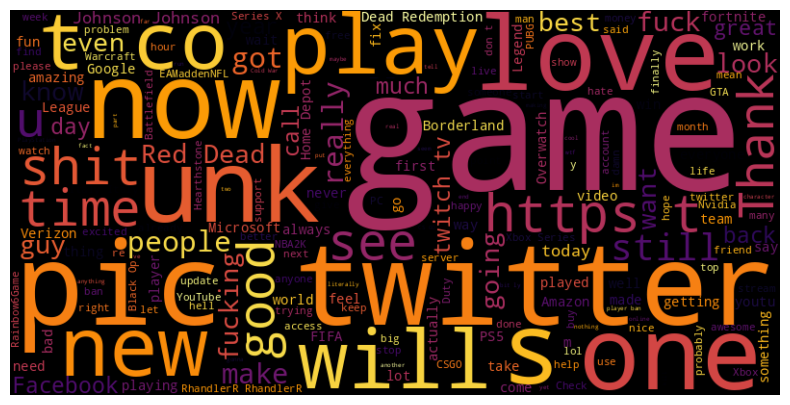

In [ ]:
plot_word_cloud(train_data,test_data,'tweet')

In [ ]:
def frequently_appearing_words(train_data,test_data,col):
  all_tweets = ' '.join(train_data[col].astype(str)) + ' ' + ' '.join(test_data[col].astype(str))

  # Tokenize and remove stopwords
  stop_words = set(stopwords.words('english'))
  tokens = all_tweets.split()
  filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

  # Get word frequency
  word_counts = Counter(filtered_tokens)

  # Plot most common words
  common_words = word_counts.most_common(10)
  words, counts = zip(*common_words)

  plt.figure(figsize=(10, 5))
  sns.barplot(x=list(words), y=list(counts))
  plt.title('Top 10 Most Frequent Words (Excluding Stopwords)')
  plt.xlabel('Words')
  plt.ylabel('Frequency')
  plt.xticks(rotation=45)
  plt.show()


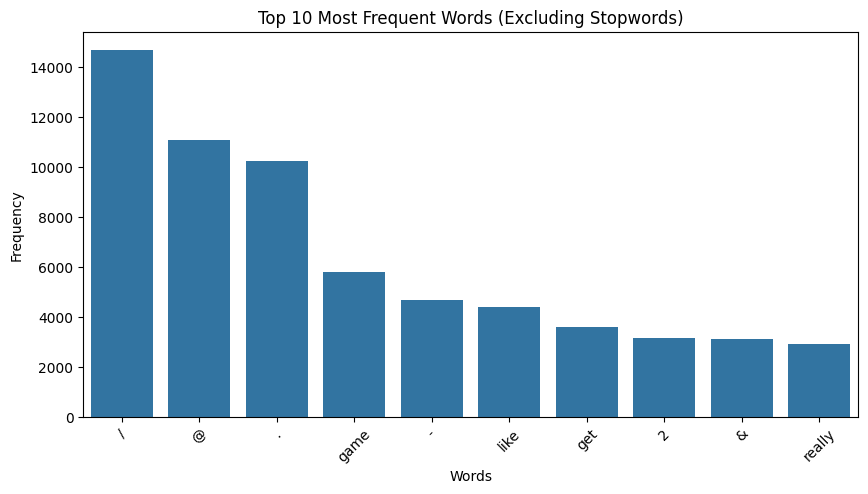

In [ ]:
frequently_appearing_words(train_data,test_data,'tweet')

## Text preprocessing

In [ ]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

In [ ]:
text_emoji_dict = {
    ";D": "😉",  # Winking face with a big grin
    ":D": "😀",  # Grinning face
    ":)": "😊",  # Smiling face
    ":(": "☹️",  # Frowning face
    ":P": "😜",  # Face with stuck-out tongue
    ":p": "😜",  # Face with stuck-out tongue (lowercase)
    ";)": "😉",  # Winking face
    ":O": "😮",  # Face with open mouth
    ":o": "😮",  # Face with open mouth (lowercase)
    ":/": "😕",  # Confused face
    ":\\": "😖",  # Confounded face
    "XD": "😂",  # Laughing face with closed eyes
    ":3": "😺",  # Cat face with smile
    ":|": "😐",  # Neutral face
    ":*": "😘",  # Face blowing a kiss
    ":$": "😳",  # Flushed face
    ":'(": "😢",  # Crying face
    "B)": "😎",  # Smiling face with sunglasses
    "<3": "❤️",  # Heart
    "</3": "💔",  # Broken heart
    ":v": "✌️",  # Victory hand
    "(y)": "👍",  # Thumbs up (commonly used in parenthesis)
    "(n)": "👎",  # Thumbs down (commonly used in parenthesis)
    ":'((": "😭",  # Loudly crying face
    "T_T": "😿",  # Crying face (often seen in anime and manga)
    ";_;": "😿",  # Crying face (sometimes seen in manga style)
    ":|]": "🤖",  # Robot face
    ":x": "❌",  # Cross mark (often representing "no")
    ":o)": "👼",  # Angel face
    ":#": "🤫",  # Shushing face
    ":@": "😡",  # Angry face
    ":))))": "😂",  # Extra happy face
    ":)))": "😂",  # Happy face
    ":]": "🙂",  # Slightly smiling face
    "=D": "😀",  # Big smile
    "=]": "🙂",  # Slightly smiling face
    "O:)": "👼",  # Angel face
    "B|": "😎",  # Cool face with sunglasses
    ":-]": "🙂",  # Smiling face
    ":-(": "☹️",  # Frowning face
    ":-)": "😊",  # Smiling face
    ":-|": "😐",  # Neutral face
    ":-O": "😮",  # Surprised face
    ':S)':'😕', #confused
}
def handle_emoji_text(text):
    # Step 1: Replace text-based emojis with Unicode emojis
    for text_emoji, unicode_emoji in text_emoji_dict.items():
        text = text.replace(text_emoji, unicode_emoji)

    # Step 2: Convert Unicode emojis to text descriptions using emoji.demojize
    text = emoji.demojize(text)

    return text



@switchfoot http:confused_face:/twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. :winking_face:  :thumbs_down:


## handling emojis and handling html characters

In [ ]:
def handle_unk(text):
    # Replace both "<unk>" and "< unk >" with an empty string
    text = re.sub(r'<\s*unk\s*>', '', text)
    return text

In [ ]:
import spacy
import re

# Load SpaCy's NER model
nlp = spacy.load("en_core_web_sm", disable=['parser', 'tagger'])
def remove_company_names(text):
    """Remove company names (ORG entities) from text."""
    list_of_companies=['Borderlands', 'CallOfDutyBlackopsColdWar', 'Amazon', 'Overwatch',
       'Xbox(Xseries)', 'NBA2K', 'Dota2', 'PlayStation5(PS5)',
       'WorldOfCraft', 'CS-GO', 'Google', 'AssassinsCreed', 'ApexLegends',
       'LeagueOfLegends', 'Fortnite', 'Microsoft', 'Hearthstone',
       'Battlefield', 'PlayerUnknownsBattlegrounds(PUBG)', 'Verizon',
       'HomeDepot', 'FIFA', 'RedDeadRedemption(RDR)', 'CallOfDuty',
       'TomClancysRainbowSix', 'Facebook', 'GrandTheftAuto(GTA)',
       'MaddenNFL', 'johnson&johnson', 'Cyberpunk2077',
       'TomClancysGhostRecon', 'Nvidia','Netflix','IPhone','MAC','Windows','Twitter',
                       'YouTube','GeForce','ChatGPT','Tesla','Ryzen','AMD','ASUS','HDMI',
                       'Apple','PS5','PS4','PS','PS3','PS2']
    list_of_companies_lower_case=[i.lower() for i in list_of_companies]

    """Remove company names from text using both NER and a predefined list."""
    doc = nlp(text)

    # Step 1: Remove company names detected by NER
    filtered_tokens = [token.text for token in doc if token.ent_type_ != "ORG"]
    cleaned_text = " ".join(filtered_tokens)

    # Step 2: Remove lowercase company names from predefined list
    pattern = r'\b(?:' + '|'.join(re.escape(company) for company in list_of_companies) + r')\b'
    cleaned_text = re.sub(pattern, '', cleaned_text, flags=re.IGNORECASE).strip()

    return cleaned_text

# Example Usage
text = "google and microsoft are leading AI research. Windows windows WINDOWS Google apple just launched a new iphone. PS5 netflix is popular."
cleaned_text = remove_company_names(text)
print(cleaned_text)



and are leading research .      just launched a new  .   is popular .


/usr/local/lib/python3.11/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [ ]:
!wget https://raw.githubusercontent.com/mammothb/symspellpy/master/symspellpy/frequency_dictionary_en_82_765.txt

--2025-03-04 07:08:42--  https://raw.githubusercontent.com/mammothb/symspellpy/master/symspellpy/frequency_dictionary_en_82_765.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1332879 (1.3M) [text/plain]
Saving to: ‘frequency_dictionary_en_82_765.txt’

frequency_dictionar 100%[===================>]   1.27M  --.-KB/s    in 0.04s   

2025-03-04 07:08:42 (29.8 MB/s) - ‘frequency_dictionary_en_82_765.txt’ saved [1332879/1332879]



## Handling chat texts

In [ ]:
chat_dict = {
    "n": "and", "s": "yes", "2 ya": "to you", "to ya": "to you", "4 ya": "for you",
    "c ya": "see you", "for ya": "for you", "2day": "today", "bro": "brother",
    "how ya": "how you", "watcha": "what are", "shoulda": "should have",
    "watcha doin": "what are you doing", "sucks": "suck", "sucked": "suck",
    "sucking": "suck", "kinda": "kind of", "sorta": "sort of", "wrd": "what are you doing",
    "lamfao": "laughing my fucking ass off", "wht": "what", "yas": "yes",
    "abt": "about", "luk": "look", "grl": "girl", "cum": "come", "boi": "boy",
    "bday": "birthday", "b day": "birthday", "asap": "as soon as possible",
    "nvm": "never mind", "dm": "direct message", "d": "the", "grt": "great",
    "fck": "fuck", "lol": "laugh out loud", "omg": "oh my god", "brb": "be right back",
    "ttyl": "talk to you later", "bff": "best friend forever", "wtf": "what the fuck",
    "idk": "I don't know", "plz": "please", "thx": "thanks", "gr8": "great",
    "w8": "wait", "h8": "hate", "u2": "you too", "l8r": "later",
    "imho": "in my humble opinion", "jk": "just kidding", "smh": "shaking my head",
    "fyi": "for your information", "xoxo": "hugs and kisses", "cya": "see you",
    "np": "no problem", "4u": "for you", "yw": "you're welcome", "tbh": "to be honest",
    "gtg": "got to go", "k": "okay", "yo": "hello", "wbu": "what about you",
    "wym": "what you mean", "fml": "fuck my life", "wyd": "what are you doing",
    "boo": "friend", "aww": "affection", "omfgz": "oh my fucking god", "msg": "message",
    "imo": "in my opinion", "paw": "parents are watching", "pitr": "parent in the room",
    "pbb": "parent behind back", "poms": "parent over my shoulder", "kpc": "keeping parents clueless",
    "mrw": "my reaction when", "ily": "I love you", "adih": "another day in hell",
    "zzz": "sleeping, bored, tired", "wywh": "wish you were here", "pov": "point of view",
    "gl": "good luck", "hbd": "happy birthday", "bf": "boyfriend", "gf": "girlfriend",
    "tysm": "thank you so much", "lmao": "laughing my ass off",
    "rn": "right now", "m": "am","im":"i am"
}

In [ ]:
def replace_chat_words(text):
    if isinstance(text, str):
        words = text.split()
        replaced_words = [chat_dict.get(word.lower(), word) for word in words]
        joined_words = ' '.join(replaced_words)

        joined_words = re.sub(r"\bi m\b", "i am", joined_words)
        joined_words = re.sub(r"\bto you\b", "to you", joined_words)
        joined_words = re.sub(r"\b4 you\b", "for you", joined_words)
        joined_words = re.sub(r"\b4 ya\b", "for you", joined_words)
        joined_words = re.sub(r"\b2 you\b", "to you", joined_words)
        joined_words = re.sub(r"\b2 ya\b", "to you", joined_words)
        joined_words = re.sub(r"\bc ya\b", "see you", joined_words)
        joined_words = re.sub(r"\bsee you\b", "see you", joined_words)

        return joined_words.strip()

    return text


In [ ]:
emotion_dict = {
    "surprise": [
        "ah", "ahhh", "ahhhh", "ahhhhh", "oh", "ohhh", "ohhhh", "ohhhhh", "whoa", "whoaa", "whoaaa", "wow", "woah", "woaaa",
        "whoops", "huh", "no way", "seriously", "really?"
    ],
    "disgust": [
        "ew", "ewww", "ewwww", "ewwwww", "yuck", "yucky", "gross", "nasty", "bleh", "ugh", "yikes", "blech", "barf", "vomit",
        "gag", "puke", "sick", "shudder"
    ],
    "fear": [
        "ahh", "eek", "ohno", "ohnoooo", "noooo", "nooooo", "scared", "frightened", "help", "panic", "terrified", "shocked",
        "spooked", "freaked", "yikes", "shudder", "screech", "screaming", "gasp"
    ],
    "happiness": [
        "yay", "wohoo", "whoohoo",'hah' "yayyy", "yass", "yasss", "hehe", "haha", "hooray", "yippee", "woohoo", "whee", "yup",
        "whoo", "wooo", "yayyy", "yasss", "yayyy", "laughter", "chuckle", "giggle", "snicker",'woa'
    ],
    "sadness": [
        "sob", "cry", "tears", "sigh", "sad", "waah", "waaaa", "boohoo", "sniffle", "wail", "sniff", "whimper", "weep",
        "sniffing", "blubber", "despair", "gasp"
    ],
    "excitement": [
        "woo", "wooo",'woo', "wooohoo", "yayyyy",'yesss', "yaay", "yaaaay", "excited", "yippee", "whoop", "wooohooo", "hype", "yeah",
        "wahoo", "booyah", "let's go", "jump", "bounce", "get hyped", "pumped", "woot", "yeeeah",'ha'
    ],
    "anger": [
        "grr", "grrrr", "arrgh", "ugh", "ughhh", "arghhh", "noooo", "damn", "dammit", "shit", "pissed", "furious", "irritated",
        "annoyed", "angry", "rage", "livid", "fuming", "growl", "sigh", "huff", "groan", "grumble"
    ],
    "love": [
        "aw", "aww", "yay", "sweet", "adorable", "cute", "love", "heart", "xoxo", "hug", "kiss", "muah", "swoon", "feels",
        "heartfelt", "romantic", "my love", "forever", "mine", "baby", "babe"
    ],
    "boredom": [
        "meh", "blah", "sigh", "yawn", "bored", "uninterested", "tired", "apathetic"
    ],
    "confusion": [
        "huh", "what?", "eh", "umm", "uh", "hmmm", "no idea", "IDK", "beats me", "confused", "perplexed", "puzzled",
        "wth", "wtf", "shaking head"
    ],
    "shame": [
        "oops", "whoops", "sorry", "embarrassed", "blushing", "awkward", "guilt", "my bad", "facepalm", "red-faced",
        "cringe", "yikes", "blush"
    ],
    "pride": [
        "yeah", "whew", "whoo", "hell yeah", "that's right", "woohoo", "yes", "we did it", "booyah", "gotcha", "rock on",
        "congratulations", "you go", "victory", "champion"
    ],
    "relief": [
        "phew", "whew"
    ]
}

# Normalize repeated characters for emotional expressions
def normalize_repeated_characters(text):
    # Normalize repeated characters for words like "ahhh", "ohhh", "ewww"
    text = re.sub(r'(ah|oh|ew|woo|yay|grr)\1{1,}', r'\1', text)
    return text

def replace_emotions(text):
    # Step 1: Normalize repeated characters first
    text = normalize_repeated_characters(text)

    # Step 2: Loop through the emotion_dict and replace expressions with emotions
    for emotion, words in emotion_dict.items():
        for word in words:
            # Use regex to replace word (case insensitive)
            text = re.sub(r'\b' + re.escape(word) + r'\b', emotion, text, flags=re.IGNORECASE)

    return text


In [ ]:
from symspellpy import SymSpell, Verbosity

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
sym_spell.load_dictionary("frequency_dictionary_en_82_765.txt", term_index=0, count_index=1)


def correct_sentence(sentence):
    words = sentence.split()
    corrected_words = [
        sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)[0].term if sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2) else word
        for word in words
    ]
    return " ".join(corrected_words)


In [ ]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Function for batch lemmatization
def batch_lemmatization(texts):
    """Lemmatize a list of texts."""
    docs = list(nlp.pipe(texts, batch_size=100))
    return [" ".join([token.lemma_ for token in doc]) for doc in docs]


In [ ]:
import re

def fix_contractions(text):
    text = re.sub(r'[ ]+', ' ', text).strip()

    text = re.sub(r"\b(\w+)\s*'\s*t\b", r"\1't", text)  # Fix "didn ' t" -> "didn't"
    text = re.sub(r"\b(\w+)\s*'\s*s\b", r"\1's", text)    # Fix "it ' s" -> "it's"
    text = re.sub(r"\b(\w+)\s*'\s*m\b", r"\1'm", text)    # Fix "I ' m" -> "I'm"
    text = re.sub(r"\b(\w+)\s*'\s*ve\b", r"\1've", text)  # Fix "I ' ve" -> "I've"
    text = re.sub(r"\b(\w+)\s*'\s*d\b", r"\1'd", text)    # Fix "he ' d" -> "he'd"
    text = re.sub(r"\b(\w+)\s*'\s*re\b", r"\1're", text)  # Fix "you ' re" -> "you're"
    text = re.sub(r"\b(\w+)\s*'\s*ll\b", r"\1'll", text)  # Fix "she ' ll" -> "she'll"

    return text

In [ ]:
import html
def clean_encoding(text):

    text = text.replace('ï¿½', "'")
    #print(f"After manual encoding fix: {text}")

    # Decode HTML entities (e.g., &lt; -> <, &quot; -> ")
    text = html.unescape(text)
    #print(f"After unescaping HTML entities: {text}")

    return text

In [ ]:
def normalize_quotes(text):
    text = re.sub(r"[‘’]", "'", text)
    text = re.sub(r"[“”]", '"', text)
    return text

In [ ]:
def normalize_elongated(text):
    text = text.lower()

    # Reduce repeated characters:
    # - If the whole word is made of one repeated letter, keep only one
    # - Otherwise, reduce repeated characters to a maximum of 2
    words = text.split()
    processed_words = [
        re.sub(r'(.)\1+', r'\1', word) if len(set(word)) == 1  # If only one unique letter, keep single letter
        else re.sub(r'(.)\1{2,}', r'\1\1', word)  # Otherwise, reduce to max 2 occurrences
        for word in words
    ]
    text=' '.join(processed_words)

    return text


In [ ]:
from nltk.tokenize import TweetTokenizer


donot_remove = {'am','not', 'have', 'has', 'must', 'should', 'had', 'might','never','was'}
stop_words = set(stopwords.words('english')) - donot_remove

tokenizer = TweetTokenizer(preserve_case=False, strip_handles=False, reduce_len=True)

In [ ]:
def clean_text(text):
  if isinstance(text,str):
    text = clean_encoding(text)
    text = emoji.demojize(text)
    text = handle_emoji_text(text)


    text = text.lower()

    text = normalize_quotes(text)
    text = fix_contractions(text)
    text = fix(text)


    text = re.sub(r'http\S+|www\S+|[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}(?:/\S*)?', "", text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#(\w+)',r'\1',text)

    text = remove_company_names(text)

    text = normalize_elongated(text)

    text = replace_chat_words(text)
    text = replace_emotions(text)


    text = re.sub(r"[^a-zA-Z\s]",'',text)
    text = re.sub(r"\s+", " ", text).strip()
    text = correct_sentence(text)
    text = batch_lemmatization([text])[0]
    tokens = tokenizer.tokenize(text)
    tokens=[word for word in tokens if word not in stop_words]


    return tokens
  return text


In [ ]:
train_data['processed_text']=train_data['tweet'].apply(clean_text)
test_data['processed_text']=test_data['tweet'].apply(clean_text)

In [ ]:
train_data['processed_text']

,processed_text
0,"[am, getting, murder]"
1,"[am, coming, borders, kill]"
2,"[am, getting, kill]"
3,"[am, coming, murder]"
4,"[am, getting, murder]"
...,...
74677,"[realized, partition, like, years, behind, dri..."
74678,"[realized, window, partition, years, behind, d..."
74679,"[realized, partition, years, behind, drivers, ..."
74680,"[realized, partition, like, years, behind, dri..."


In [ ]:
train_data

,id,entity,sentiment,tweet,processed_text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,"[am, getting, murder]"
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,"[am, coming, borders, kill]"
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,"[am, getting, kill]"
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,"[am, coming, murder]"
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,"[am, getting, murder]"
...,...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...,"[realized, partition, like, years, behind, dri..."
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...,"[realized, window, partition, years, behind, d..."
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...,"[realized, partition, years, behind, drivers, ..."
74680,9200,Nvidia,Positive,Just realized between the windows partition of...,"[realized, partition, like, years, behind, dri..."


In [ ]:
train=train_data.copy()
test=test_data.copy()

In [ ]:
train['sentiment'].value_counts()

,count
sentiment,
Negative,22358
Positive,20655
Neutral,18108
Irrelevant,12875


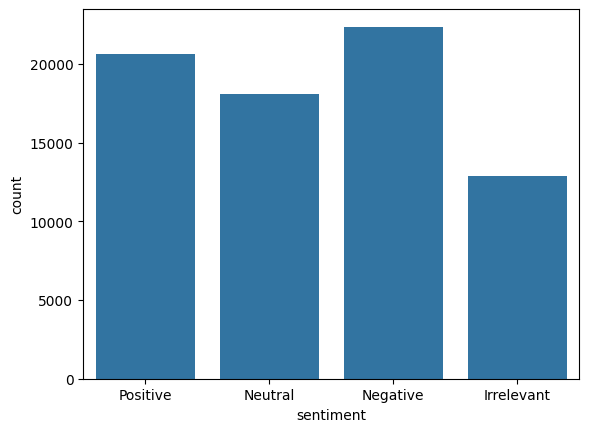

In [ ]:
sns.countplot(x='sentiment',data=train)
plt.show()

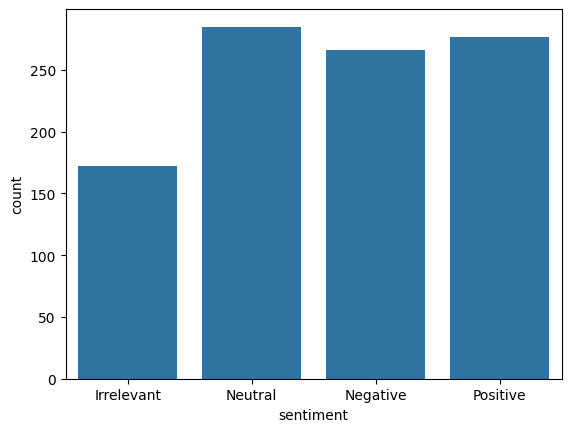

In [ ]:
sns.countplot(x='sentiment',data=test)
plt.show()

In [ ]:
# remove irrelevant

train=train[train['sentiment']!='Irrelevant']
train['sentiment'].value_counts()

,count
sentiment,
Negative,22358
Positive,20655
Neutral,18108


In [ ]:
train.shape

(61121, 5)

In [ ]:
test=test[test['sentiment']!='Irrelevant']
test['sentiment'].value_counts()

,count
sentiment,
Neutral,285
Positive,277
Negative,266


In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [ ]:
le=LabelEncoder()
train_data['sentiment']=le.fit_transform(train_data['sentiment'])
test_data['sentiment']=le.transform(test_data['sentiment'])

In [ ]:
path='/content/MyDrive/MyDrive/Twitter sentiment analysis processed data/label_encoder.pkl'
with open(path, "wb") as f:
    pickle.dump(le, f)


In [ ]:
# Load the LabelEncoder from the pickle file
with open(path, "rb") as f:
    le = pickle.load(f)

In [ ]:
train=pd.read_csv('/content/MyDrive/MyDrive/Twitter sentiment analysis processed data/train_tweets.csv')
test=pd.read_csv('/content/MyDrive/MyDrive/Twitter sentiment analysis processed data/test_tweets.csv')
train.head()

,id,entity,sentiment,tweet,processed_text
0,2401,Borderlands,2,im getting on borderlands and i will murder yo...,"['am', 'getting', 'murder']"
1,2401,Borderlands,2,I am coming to the borders and I will kill you...,"['am', 'coming', 'borders', 'kill']"
2,2401,Borderlands,2,im getting on borderlands and i will kill you ...,"['am', 'getting', 'kill']"
3,2401,Borderlands,2,im coming on borderlands and i will murder you...,"['am', 'coming', 'murder']"
4,2401,Borderlands,2,im getting on borderlands 2 and i will murder ...,"['am', 'getting', 'murder']"


In [ ]:
train['sentiment'].value_counts()

,count
sentiment,
0,22358
2,20655
1,18108


In [ ]:
test['sentiment'].value_counts()

,count
sentiment,
1,285
2,277
0,266


In [ ]:
import ast
train['processed_text'] = train['processed_text'].apply(lambda x: ast.literal_eval(x))
test['processed_text'] = test['processed_text'].apply(lambda x: ast.literal_eval(x))

In [ ]:
csv_path = "/content/drive/My Drive/Twitter_Sentiment_Analysis/processed_tweets"
os.makedirs(csv_path, exist_ok=True)

train['processed_text'] = train['processed_text'].apply(lambda x: ','.join(x))
test['processed_text'] = test['processed_text'].apply(lambda x: ','.join(x))


train_data.to_csv(os.path.join(csv_path, "train_tweets.csv"), index=False)
test_data.to_csv(os.path.join(csv_path, "test_tweets.csv"), index=False)

import pickle

with open("text_preprocessing.pkl", "wb") as f:
    pickle.dump(clean_text, f)

print("Function saved successfully!")


Function saved successfully!


In [ ]:
train

,id,entity,sentiment,tweet,processed_text
0,2401,Borderlands,2,im getting on borderlands and i will murder yo...,"[am, getting, murder]"
1,2401,Borderlands,2,I am coming to the borders and I will kill you...,"[am, coming, borders, kill]"
2,2401,Borderlands,2,im getting on borderlands and i will kill you ...,"[am, getting, kill]"
3,2401,Borderlands,2,im coming on borderlands and i will murder you...,"[am, coming, murder]"
4,2401,Borderlands,2,im getting on borderlands 2 and i will murder ...,"[am, getting, murder]"
...,...,...,...,...,...
61116,9200,Nvidia,2,Just realized that the Windows partition of my...,"[realized, partition, like, years, behind, dri..."
61117,9200,Nvidia,2,Just realized that my Mac window partition is ...,"[realized, window, partition, years, behind, d..."
61118,9200,Nvidia,2,Just realized the windows partition of my Mac ...,"[realized, partition, years, behind, drivers, ..."
61119,9200,Nvidia,2,Just realized between the windows partition of...,"[realized, partition, like, years, behind, dri..."


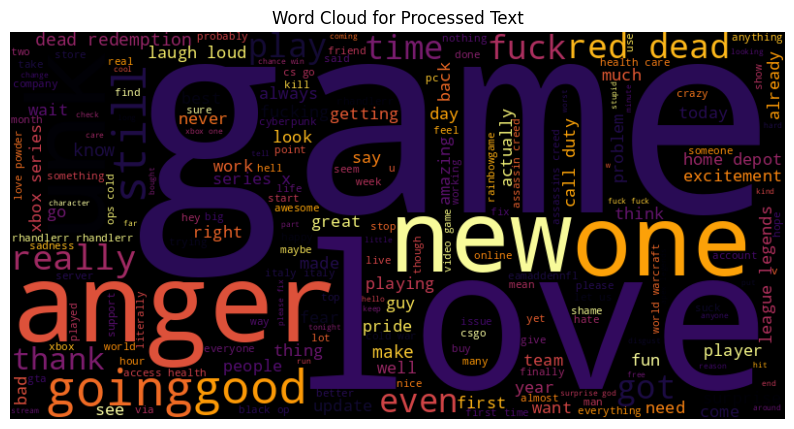

In [ ]:
train_processed_text = ' '.join(train['processed_text'].apply(lambda x: ' '.join(x)))
test_processed_text = ' '.join(test['processed_text'].apply(lambda x: ' '.join(x)))


combined_processed_text = train_processed_text + " " + test_processed_text


wordcloud = WordCloud(width=800, height=400,background_color='black', colormap='inferno').generate(combined_processed_text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Processed Text')
plt.show()

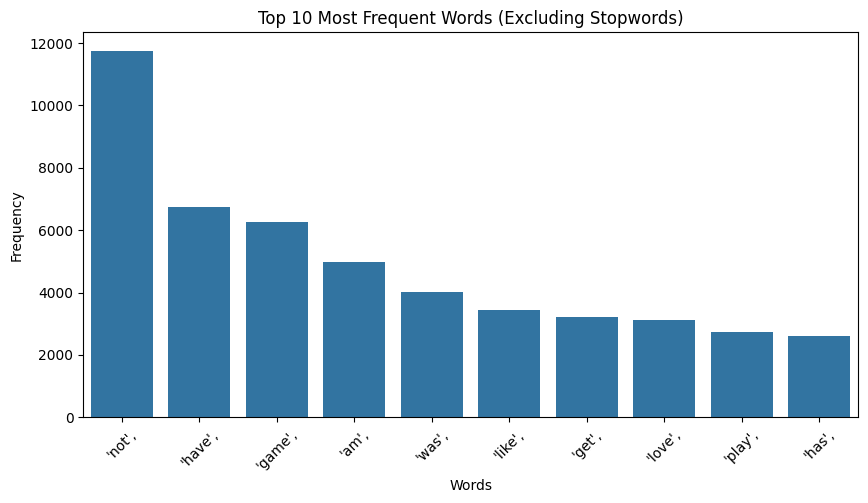

In [ ]:
frequently_appearing_words(train,test,'processed_text')

## sentiment analysis using GloVe

In [ ]:
!wget https://nlp.stanford.edu/data/glove.twitter.27B.zip

--2025-03-02 08:53:36--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2025-03-02 08:53:36--  https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [application/zip]
Saving to: ‘glove.twitter.27B.zip’

glove.twitter.27B.z 100%[===================>]   1.42G  3.31MB/s    in 5m 21s  

2025-03-02 08:58:58 (4.52 MB/s) - ‘glove.twitter.27B.zip’ saved [1520408563/1520408563]



In [ ]:
#unzip
import zipfile
zip_ref=zipfile.ZipFile('/content/glove.twitter.27B.zip')
zip_ref.extractall()
zip_ref.close()

In [ ]:
train_texts = train['processed_text'].fillna("")
test_texts = test['processed_text'].fillna("")
train_labels = train['sentiment'].values
test_labels = test['sentiment'].values

In [ ]:
train_texts

,processed_text
0,"[am, getting, murder]"
1,"[am, coming, borders, kill]"
2,"[am, getting, kill]"
3,"[am, coming, murder]"
4,"[am, getting, murder]"
...,...
61116,"[realized, partition, like, years, behind, dri..."
61117,"[realized, window, partition, years, behind, d..."
61118,"[realized, partition, years, behind, drivers, ..."
61119,"[realized, partition, like, years, behind, dri..."


In [ ]:
train_texts.shape,test_texts.shape

((61121,), (828,))

## Finding the optimal num_words

In [ ]:
from collections import Counter
word_counts = Counter(word for tweet in train_texts for word in tweet)

sorted_counts=sorted(word_counts.values(),reverse=True)
sorted_counts[:10]

[13725, 7719, 7356, 6657, 4607, 4389, 3901, 3582, 3450, 3071]

In [ ]:
print(word_counts.most_common(50))  # Show top 20 words with counts


[('not', 13725), ('have', 7719), ('game', 7356), ('am', 6657), ('was', 4607), ('love', 4389), ('like', 3901), ('anger', 3582), ('get', 3450), ('play', 3071), ('one', 2958), ('good', 2896), ('new', 2835), ('has', 2815), ('really', 2745), ('time', 2564), ('fuck', 2541), ('going', 2332), ('people', 2261), ('unk', 2216), ('surprise', 2172), ('still', 2145), ('got', 2075), ('games', 1955), ('best', 1909), ('playing', 1899), ('us', 1857), ('see', 1838), ('would', 1825), ('dead', 1822), ('great', 1800), ('even', 1788), ('please', 1788), ('fucking', 1723), ('go', 1711), ('red', 1668), ('had', 1658), ('back', 1639), ('xbox', 1632), ('rhandlerr', 1581), ('much', 1579), ('home', 1568), ('know', 1532), ('want', 1520), ('fix', 1457), ('first', 1423), ('pride', 1418), ('make', 1417), ('fun', 1352), ('day', 1349)]


In [ ]:
#Find the total number of words that covers 90% of occurences
total_words=sum(sorted_counts)
running_sum=0
num_words=0
for count in sorted_counts:
  running_sum+=count
  num_words+=1
  if running_sum/total_words >= 0.90:
    break
print(f'Optimal num_words for 90% coverage: {num_words}')


Optimal num_words for 90% coverage: 5756


In [ ]:
import numpy as np
np.bincount(train_labels)  # Count occurrences of each class

array([20655, 18108, 22358])

In [ ]:
train_labels

array(['Positive', 'Positive', 'Positive', ..., 'Positive', 'Positive',
       'Positive'], dtype=object)

In [ ]:
train_texts=train['processed_text']
test_texts=test['processed_text']

In [ ]:
train_texts,test_texts

(0                                    [am, getting, murder]
 1                              [am, coming, borders, kill]
 2                                      [am, getting, kill]
 3                                     [am, coming, murder]
 4                                    [am, getting, murder]
                                ...                        
 61116    [realized, partition, like, years, behind, dri...
 61117    [realized, window, partition, years, behind, d...
 61118    [realized, partition, years, behind, drivers, ...
 61119    [realized, partition, like, years, behind, dri...
 61120    [like, partition, like, years, behind, drivers...
 Name: processed_text, Length: 61121, dtype: object,
 0      [boss, jeff, bezos, rejects, claims, company, ...
 1      [pay, word, functions, poorly, chromebook, fac...
 2      [csgo, matchmaking, full, closet, hacking, tru...
 3      [president, slapping, americans, face, really,...
 4      [hi, have, had, madeleine, mccann, cellar, pas.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np


num_words = 20000  # Maximum allowed vocabulary size
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words = num_words,oov_token=oov_token)
tokenizer.fit_on_texts(train_texts)

# Convert text to sequences
x_train = tokenizer.texts_to_sequences(train_texts)
x_test = tokenizer.texts_to_sequences(test_texts)

vocab_size = len(tokenizer.word_index) +1


'''x_train = [[min(w, vocab_size - 1) for w in seq] for seq in x_train]
x_test = [[min(w, vocab_size - 1) for w in seq] for seq in x_test]'''

oov_token_index = tokenizer.word_index.get("<OOV>", 1)

# Replace out-of-bounds indices with the OOV token index
#x_train = [[w if w < vocab_size else oov_token_index for w in seq] for seq in x_train]
#x_test = [[w if w < vocab_size else oov_token_index for w in seq] for seq in x_test]


#x_train = [[w if w < vocab_size else 1 for w in seq] for seq in x_train]
#x_test = [[w if w < vocab_size else 1 for w in seq] for seq in x_test]

x_train = [[min(idx, vocab_size - 1) for idx in seq] for seq in x_train]
x_test = [[min(idx, vocab_size - 1) for idx in seq] for seq in x_test]

# Compute max sequence length (95th percentile)
max_length = int(np.percentile([len(seq) for seq in x_train], 95))

# Pad sequences
x_train = pad_sequences(x_train, maxlen=max_length, padding="post",truncating='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding="post",truncating='post')

word_index = tokenizer.word_index



# Debugging info
print("Max word index:", max(word_index.values()))
print(f"Unique words in training set: {len(word_index)}")
print(f"Max sequence length: {max_length}")



Max word index: 24859
Unique words in training set: 24859
Max sequence length: 26


In [ ]:
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)


In [ ]:
x_train

array([[   5,   74, 1371, ...,    0,    0,    0],
       [   5,  243, 5427, ...,    0,    0,    0],
       [   5,   74,  295, ...,    0,    0,    0],
       ...,
       [1832, 9320,   86, ...,    0,    0,    0],
       [1832, 9320,    8, ...,    0,    0,    0],
       [   8, 9320,    8, ...,    0,    0,    0]], dtype=int32)

In [ ]:
max_length

26

In [ ]:
oov_count = sum(1 for seq in x_train for w in seq if w == 1)
print("OOV Token Count in Training Data:", oov_count)

OOV Token Count in Training Data: 0


In [ ]:
type(x_train),type(x_test)

(numpy.ndarray, numpy.ndarray)

In [ ]:
len(x_train)

61121

In [ ]:
y_train = train['sentiment'].values
y_test = test['sentiment'].values

In [ ]:
y_train,y_test

(array([2, 2, 2, ..., 2, 2, 2]),
 array([1, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 0, 1, 0, 2, 2, 0, 2, 0, 0, 1, 0,
        1, 1, 0, 0, 2, 2, 0, 2, 0, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 0, 0, 0,
        1, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 1, 0, 1, 0, 2, 0, 0, 2,
        2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 0, 0, 1, 1, 0, 2, 0, 0, 0, 1, 2, 1,
        0, 2, 2, 1, 2, 1, 2, 0, 1, 1, 1, 0, 1, 0, 1, 1, 2, 2, 1, 0, 0, 2,
        0, 1, 0, 2, 1, 0, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 0, 1, 1,
        1, 1, 0, 1, 2, 0, 1, 0, 1, 0, 0, 0, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2,
        1, 0, 0, 1, 2, 2, 1, 2, 2, 1, 1, 0, 0, 0, 0, 2, 1, 1, 2, 2, 2, 2,
        0, 2, 2, 1, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 1, 0, 1, 1,
        2, 0, 2, 2, 1, 2, 0, 0, 2, 2, 2, 2, 1, 1, 2, 0, 1, 2, 1, 0, 1, 1,
        0, 2, 2, 0, 1, 2, 1, 0, 1, 0, 2, 2, 0, 0, 0, 2, 0, 1, 2, 1, 1, 0,
        2, 0, 2, 0, 1, 1, 2, 0, 1, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0,
        1, 1, 1, 2, 1, 2, 0, 1, 1, 1, 1, 0, 2, 0, 0, 2, 2, 1, 1, 0, 0, 0,
     

In [ ]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

y_train.shape,y_test.shape

((61121, 3), (828, 3))

In [ ]:
import numpy as np

# Save all datasets in a single .npz file
np.savez("train_test_split.npz", x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

In [ ]:
y_train.shape,y_test.shape

((61121, 3), (828, 3))

In [ ]:
x_train.shape,train_labels.shape

((61121, 26), (61121,))

In [ ]:
x_train[:1]

array([[   5,   74, 1371,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]], dtype=int32)

In [ ]:
x_train.shape,x_test.shape

((61121, 26), (828, 26))

In [ ]:
x_train[:10]

array([[   5,   74, 1371,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [   5,  243, 5427,  295,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [   5,   74,  295,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [   5,  243, 1371,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [   5,   74, 1371,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [   5,   74, 1371,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,  

In [ ]:
x_train.shape[1]

26

In [ ]:
import numpy as np

embedding_dim = 100
embedding_matrix = np.random.uniform(-0.05, 0.05, (vocab_size, embedding_dim))

word_found = 0
with open("glove.twitter.27B.100d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        if word in tokenizer.word_index and tokenizer.word_index[word] < vocab_size - 1:
            embedding_matrix[tokenizer.word_index[word]] = np.asarray(values[1:], dtype='float32')
            word_found += 1

# Compute mean of known embeddings only if there are known words
known_embeddings = embedding_matrix[np.any(embedding_matrix != 0, axis=1)]
if word_found > 0:
    mean_embedding = np.mean(known_embeddings, axis=0)
else:
    mean_embedding = np.random.uniform(-0.05, 0.05, embedding_dim)

embedding_matrix[np.all(embedding_matrix == 0, axis=1)] = mean_embedding

print(f"Embedding matrix shape: {embedding_matrix.shape}")
print(f"Words found in GloVe: {word_found}")



Embedding matrix shape: (24860, 100)
Words found in GloVe: 17768


In [ ]:
#normalize the embedding
from sklearn.preprocessing import normalize
embedding_matrix = normalize(embedding_matrix, axis=1)

In [ ]:
np.save('embedding_matrix.npy', embedding_matrix)

In [ ]:
embedding_matrix[:1]

array([[ 8.87296790e-02,  1.60589848e-01, -4.74073226e-02,
         7.40612020e-02,  1.66390977e-02, -2.55686340e-02,
        -1.03743416e-02, -4.79608622e-02, -3.96791531e-03,
        -8.62817052e-02,  2.00985408e-02,  1.32901610e-01,
        -9.37251283e-03,  1.71556423e-01,  1.90740911e-03,
         1.31838068e-04,  4.76893040e-03, -8.71495779e-02,
         1.13241497e-01, -3.47873609e-02,  1.49138322e-01,
         7.46001475e-03, -5.44137304e-02, -1.29701699e-01,
        -4.29098867e-02,  6.87283018e-02,  6.54646436e-02,
         1.17676020e-01,  1.02157432e-01,  6.65884980e-02,
         1.30131665e-01,  2.95275442e-02,  1.42860304e-01,
        -1.35458305e-01,  6.04620324e-02,  6.23902660e-02,
         1.19269631e-01, -1.70159160e-01,  1.31272603e-01,
        -8.77814722e-02, -5.63169041e-02, -1.44346595e-01,
        -2.21109949e-02,  3.97236852e-02,  1.57475361e-01,
         1.03476995e-01, -8.36640537e-02, -1.44570682e-01,
        -1.71804988e-01,  1.61967481e-01,  1.55539700e-0

## Training without using glove embedding

In [ ]:
print(tf.keras.mixed_precision.global_policy())

<DTypePolicy "float32">


In [ ]:
max_length

26

In [ ]:
num_words

20000

In [ ]:
vocab_size

20000

In [ ]:
embedding_dim,max_length

(50, 152)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  # Plot the heatmap
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False)

  plt.title('Confusion Matrix', fontsize=16)
  plt.xlabel('Predicted Labels', fontsize=12)
  plt.ylabel('True Labels', fontsize=12)


  plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.regularizers import l2
import tensorflow as tf


dep_model0= Sequential()

# Embedding Layer (Pretrained GloVe, Non-Trainable)
dep_model0.add(Embedding(input_dim=vocab_size,
                    output_dim=100,
                    input_length=max_length,
                    weights=[embedding_matrix],
                    trainable=False))


dep_model0.add(SpatialDropout1D(0.3))

dep_model0.add(LSTM(32,
               dropout=0.3,
               recurrent_dropout=0.3,
               return_sequences=False,
               kernel_regularizer=l2(0.001)))

dep_model0.add(BatchNormalization())
dep_model0.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
dep_model0.add(Dropout(0.4))

dep_model0.add(Dense(3, activation='softmax'))


dep_model0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6)
]


dep_model0.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_28 (Embedding)             │ ?                           │       2,486,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_27                 │ ?                           │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_34 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,486,000 (9.48 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,486,000 (9.48 MB)

In [ ]:
history0 = dep_model0.fit(x_train, y_train,
                        epochs=20,
                        batch_size=32,
                        validation_data=(x_test, y_test),
                        callbacks=callbacks)

Epoch 1/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 85s 41ms/step - accuracy: 0.3511 - loss: 1.2500 - val_accuracy: 0.4444 - val_loss: 1.0960 - learning_rate: 0.0010
Epoch 2/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 81s 41ms/step - accuracy: 0.4336 - loss: 1.1007 - val_accuracy: 0.4795 - val_loss: 1.0572 - learning_rate: 0.0010
Epoch 3/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 87s 44ms/step - accuracy: 0.4534 - loss: 1.0815 - val_accuracy: 0.4638 - val_loss: 1.0568 - learning_rate: 0.0010
Epoch 4/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 137s 41ms/step - accuracy: 0.4537 - loss: 1.0745 - val_accuracy: 0.4601 - val_loss: 1.0327 - learning_rate: 0.0010
Epoch 5/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 81s 40ms/step - accuracy: 0.4728 - loss: 1.0539 - val_accuracy: 0.5133 - val_loss: 0.9931 - learning_rate: 0.0010
Epoch 6/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 82s 40ms/step - accuracy: 0.4983 - loss: 1.0278 - val_accuracy: 0.5145 - val_loss: 0.9886 - learning_rate: 0.0010
Epoch 7/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 83s 41ms/step - accur

In [ ]:
dep_model0.evaluate(x_train,y_train),dep_model0.evaluate(x_test,y_test)

1911/1911 ━━━━━━━━━━━━━━━━━━━━ 35s 18ms/step - accuracy: 0.6116 - loss: 0.8798
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5644 - loss: 0.9058


([0.8805224895477295, 0.6153204441070557],
 [0.8790486454963684, 0.6050724387168884])

In [ ]:
y_pred=dep_model0.predict(x_test)
y_pred

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step


array([[0.3582, 0.495 , 0.147 ],
       [0.4463, 0.36  , 0.1938],
       [0.6157, 0.1842, 0.2001],
       ...,
       [0.375 , 0.2166, 0.4087],
       [0.1389, 0.5703, 0.291 ],
       [0.2637, 0.4597, 0.2764]], dtype=float16)

In [ ]:
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_classes[:10]

array([1, 0, 0, 1, 0, 2, 1, 2, 0, 0])

In [ ]:
y_test[:10]

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [ ]:
y_test_classes = np.argmax(y_test, axis=1)
y_test_classes[:10]

array([1, 0, 0, 1, 0, 2, 2, 2, 0, 2])

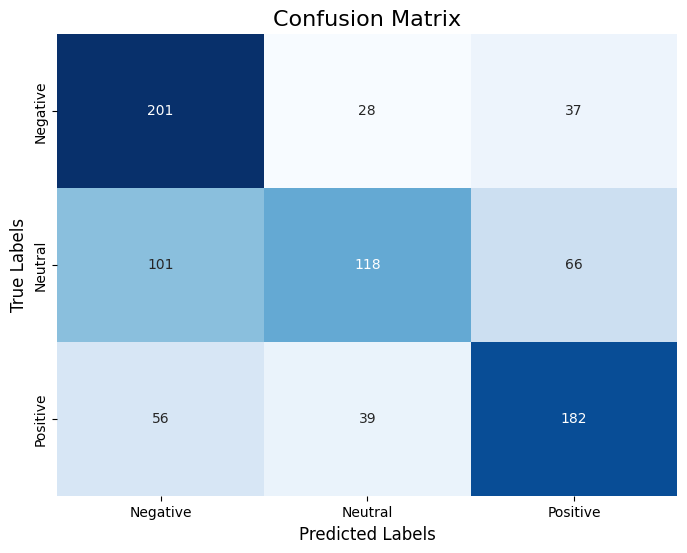

In [ ]:
cm = confusion_matrix(y_test_classes, y_pred_classes)

class_labels = ['Negative', 'Neutral','Positive']
plot_confusion_matrix(cm,class_labels)

In [ ]:
print(classification_report(y_test_classes,y_pred_classes))

              precision    recall  f1-score   support

           0       0.56      0.76      0.64       266
           1       0.64      0.41      0.50       285
           2       0.64      0.66      0.65       277

    accuracy                           0.61       828
   macro avg       0.61      0.61      0.60       828
weighted avg       0.61      0.61      0.60       828



In [ ]:
print(f'Precision: {precision_score(y_test_classes,y_pred_classes,average="weighted")}')
print(f'Recall: {recall_score(y_test_classes,y_pred_classes,average="weighted")}')
print(f'F1 Score: {f1_score(y_test_classes,y_pred_classes,average="weighted")}')

Precision: 0.6135523919915978
Recall: 0.605072463768116
F1 Score: 0.5964746621535593


## Fine-tuning using LSTM model

In [ ]:
from keras.regularizers import l2

#opt = LossScaleOptimizer(tf.keras.optimizers.AdamW(learning_rate=0.001,weight_decay=0.0001))
opt=tf.keras.optimizers.AdamW(learning_rate=0.001,weight_decay=0.0001)
embedding_dim = 100

embedding_layer=Embedding(input_dim=vocab_size,
                         output_dim=embedding_dim,
                         input_length=max_length,
                         weights=[embedding_matrix],
                         trainable=True
                         )

dep_model = Sequential()
dep_model.add(embedding_layer)

dep_model.add(SpatialDropout1D(0.2))
dep_model.add(LSTM(64, dropout=0.3, return_sequences=True,recurrent_dropout=0.3,kernel_regularizer=l2(0.005)))
dep_model.add(LayerNormalization())
dep_model.add(LSTM(32, dropout=0.3, recurrent_dropout=0.3,kernel_regularizer=l2(0.001)))
dep_model.add(BatchNormalization())
dep_model.add(Dense(64, activation='relu',kernel_regularizer=l2(0.001)))
dep_model.add(Dropout(0.3)),
dep_model.add(Dense(3, activation='softmax'))

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6)
]

dep_model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

dep_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_33 (Embedding)             │ ?                           │       2,486,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_31                 │ ?                           │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_41 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_9                │ ?                           │     0 (unbuilt) │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_42 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_63 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,486,000 (9.48 MB)

 Trainable params: 2,486,000 (9.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
x_train.shape,y_train.shape

((61121, 26), (61121, 3))

In [ ]:
print(x_train.shape)
print(x_test.shape)


(61121, 26)
(828, 26)


In [ ]:
history = dep_model.fit(x_train, y_train,
                        epochs=10,
                        batch_size=32,
                        validation_data=(x_test, y_test),
                        callbacks=callbacks)


Epoch 1/10
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 327s 148ms/step - accuracy: 0.3506 - loss: 1.4850 - val_accuracy: 0.6244 - val_loss: 0.9170 - learning_rate: 0.0010
Epoch 2/10
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 315s 145ms/step - accuracy: 0.6523 - loss: 0.8854 - val_accuracy: 0.8261 - val_loss: 0.5310 - learning_rate: 0.0010
Epoch 3/10
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 281s 147ms/step - accuracy: 0.7561 - loss: 0.6751 - val_accuracy: 0.8732 - val_loss: 0.4186 - learning_rate: 0.0010
Epoch 4/10
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 272s 142ms/step - accuracy: 0.7934 - loss: 0.5868 - val_accuracy: 0.8961 - val_loss: 0.3500 - learning_rate: 0.0010
Epoch 5/10
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 317s 140ms/step - accuracy: 0.8122 - loss: 0.5358 - val_accuracy: 0.9022 - val_loss: 0.3133 - learning_rate: 0.0010
Epoch 6/10
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 269s 141ms/step - accuracy: 0.8243 - loss: 0.5054 - val_accuracy: 0.9070 - val_loss: 0.2849 - learning_rate: 0.0010
Epoch 7/10
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 271s 142ms

In [ ]:
dep_model.evaluate(x_train,y_train),dep_model.evaluate(x_test,y_test)

1911/1911 ━━━━━━━━━━━━━━━━━━━━ 59s 31ms/step - accuracy: 0.8986 - loss: 0.2887
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9258 - loss: 0.2487


([0.29294896125793457, 0.8970403075218201],
 [0.235667422413826, 0.9275362491607666])

In [ ]:
y_pred=dep_model.predict(x_test)
y_pred

26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step


array([[0.003887, 0.9893  , 0.006435],
       [0.9893  , 0.00621 , 0.005272],
       [0.997   , 0.002321, 0.001105],
       ...,
       [0.007965, 0.04175 , 0.9497  ],
       [0.00304 , 0.003933, 0.993   ],
       [0.001526, 0.995   , 0.002625]], dtype=float16)

In [ ]:
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_classes[:10]

array([1, 0, 0, 1, 0, 2, 2, 2, 0, 2])

In [ ]:
y_test[:10]

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [ ]:
y_test_classes = np.argmax(y_test, axis=1)  # Convert one-hot to class labels

In [ ]:
# Print the classes that were encoded
print("Classes: ", le.classes_)

# To map the predicted labels or encoded labels back to original sentiment labels
predicted_sentiment = le.inverse_transform(y_pred_classes)
print(predicted_sentiment[:10])  # Show the first 10 predictions as an example


Classes:  ['Negative' 'Neutral' 'Positive']
['Neutral' 'Negative' 'Negative' 'Neutral' 'Negative' 'Positive'
 'Positive' 'Positive' 'Negative' 'Positive']


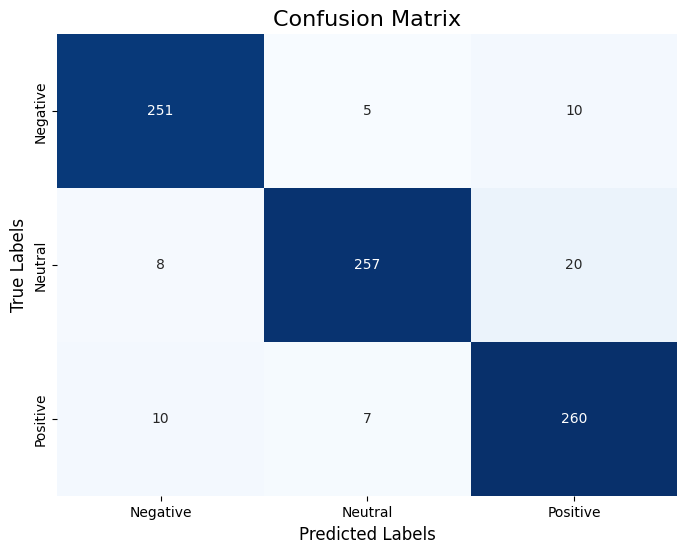

In [ ]:
cm = confusion_matrix(y_test_classes, y_pred_classes)

class_labels = ['Negative', 'Neutral','Positive']
plot_confusion_matrix(cm,class_labels)

In [ ]:
print(classification_report(y_test_classes,y_pred_classes))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       266
           1       0.96      0.90      0.93       285
           2       0.90      0.94      0.92       277

    accuracy                           0.93       828
   macro avg       0.93      0.93      0.93       828
weighted avg       0.93      0.93      0.93       828



In [ ]:
print(f'Precision: {precision_score(y_test_classes,y_pred_classes,average="weighted")}')
print(f'Recall: {recall_score(y_test_classes,y_pred_classes,average="weighted")}')
print(f'F1 Score: {f1_score(y_test_classes,y_pred_classes,average="weighted")}')

Precision: 0.9285408411036118
Recall: 0.927536231884058
F1 Score: 0.9276010950983495


In [ ]:
dep_model.save("dep_model.h5")

In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model("dep_model.h5")

## Using bidirectional LSTM

In [ ]:
loaded_embedding_matrix = np.load('/content/MyDrive/MyDrive/Twitter sentiment analysis processed data/embedding_matrix.npy')
loaded_embedding_matrix

array([[ 0.08872968,  0.16058985, -0.04740732, ..., -0.14386288,
         0.14458442,  0.02291433],
       [ 0.11608713, -0.13651158,  0.17081344, ..., -0.17643104,
        -0.18213299, -0.17530424],
       [ 0.01241459, -0.01357661,  0.012766  , ...,  0.02603171,
         0.04270513, -0.03711086],
       ...,
       [-0.12463935, -0.03472968,  0.06202514, ...,  0.07412264,
        -0.10311823, -0.1816047 ],
       [ 0.00593259,  0.14082459,  0.07829247, ...,  0.01345129,
        -0.06081255, -0.09456812],
       [-0.09680435,  0.03819648,  0.15388819, ..., -0.01126271,
         0.04788425,  0.15393472]])

In [ ]:
import pickle

# Load the tokenizer from the pickle file
with open("/content/MyDrive/MyDrive/Twitter sentiment analysis processed data/tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

24860

In [ ]:
dep_model3 = Sequential()

opt=tf.keras.optimizers.AdamW(learning_rate=0.001,weight_decay=0.0001)

embedding_layer1 = Embedding(input_dim=vocab_size,
                             output_dim=100,
                             input_length=26,
                             weights=[loaded_embedding_matrix],
                             trainable=False)

dep_model3.add(embedding_layer1)

dep_model3.add(Bidirectional(LSTM(64, dropout=0.3, return_sequences=False, recurrent_dropout=0.3, kernel_regularizer=l2(0.001))))
dep_model3.add(BatchNormalization())
dep_model3.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
dep_model3.add(BatchNormalization())
dep_model3.add(Dropout(0.3))
dep_model3.add(Dense(3, activation='softmax'))

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6)
]

dep_model3.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
dep_model3.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │       2,486,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_4                │ ?                           │     0 (unbuilt) │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,486,000 (9.48 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,486,000 (9.48 MB)

In [ ]:
y_train

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(61121, 26)
(61121, 3)
(828, 26)
(828, 3)


In [ ]:
history3 = dep_model3.fit(x_train, y_train,
                        epochs=20,
                        batch_size=32,
                        validation_data=(x_test, y_test),
                        callbacks=callbacks)

Epoch 1/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 86s 41ms/step - accuracy: 0.4758 - loss: 1.2932 - val_accuracy: 0.5725 - val_loss: 0.9899 - learning_rate: 0.0010
Epoch 2/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 72s 36ms/step - accuracy: 0.5745 - loss: 0.9828 - val_accuracy: 0.6196 - val_loss: 0.8806 - learning_rate: 0.0010
Epoch 3/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 81s 36ms/step - accuracy: 0.5874 - loss: 0.9361 - val_accuracy: 0.6232 - val_loss: 0.8577 - learning_rate: 0.0010
Epoch 4/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 81s 36ms/step - accuracy: 0.5947 - loss: 0.9177 - val_accuracy: 0.6232 - val_loss: 0.8810 - learning_rate: 0.0010
Epoch 5/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 83s 36ms/step - accuracy: 0.6059 - loss: 0.8986 - val_accuracy: 0.6353 - val_loss: 0.8174 - learning_rate: 5.0000e-04
Epoch 6/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 82s 36ms/step - accuracy: 0.6106 - loss: 0.8879 - val_accuracy: 0.6461 - val_loss: 0.8303 - learning_rate: 5.0000e-04
Epoch 7/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 82s 36ms/step 

In [ ]:
dep_model3.evaluate(x_train,y_train),dep_model3.evaluate(x_test,y_test)

1911/1911 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.6659 - loss: 0.7849
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6573 - loss: 0.7753


([0.7883683443069458, 0.6624727845191956],
 [0.7538659572601318, 0.6787439584732056])

In [ ]:
def plot_loss_acc_curves(history):
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.figure()
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

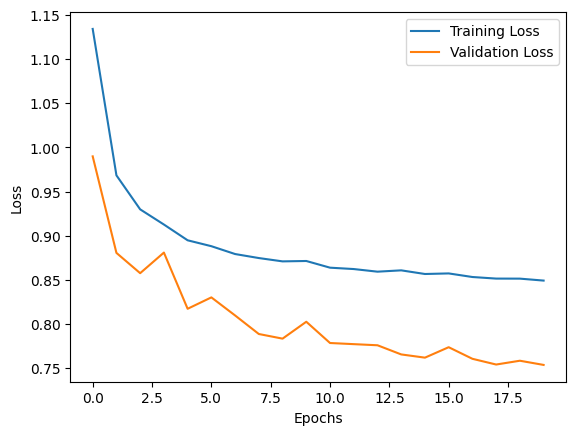

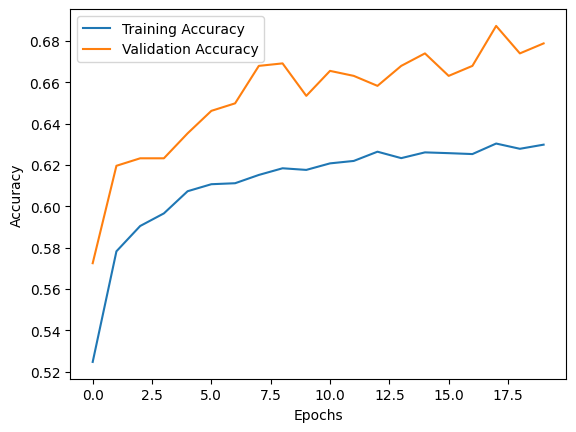

In [ ]:
plot_loss_acc_curves(history3)

In [ ]:
y_test[:5]

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [ ]:
y_test_classes=np.argmax(y_test,axis=1)
y_test_classes[:5]

array([1, 0, 0, 1, 0])

In [ ]:
y_pred=dep_model3.predict(x_test)
y_pred

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step


array([[0.2199551 , 0.7154305 , 0.06461444],
       [0.49089783, 0.32952544, 0.17957665],
       [0.8600446 , 0.07735112, 0.06260435],
       ...,
       [0.28732038, 0.25873438, 0.45394522],
       [0.10358468, 0.43117994, 0.46523532],
       [0.1294391 , 0.7298789 , 0.14068197]], dtype=float32)

In [ ]:
y_pred_classes=np.argmax(y_pred,axis=1)
y_pred_classes[:10]

array([1, 0, 0, 1, 0, 2, 1, 2, 0, 0])

In [ ]:
import pickle

# Load the tokenizer from the pickle file
with open("/content/MyDrive/MyDrive/Twitter sentiment analysis processed data/label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

In [ ]:
print("Classes: ", le.classes_)

Classes:  ['Negative' 'Neutral' 'Positive']


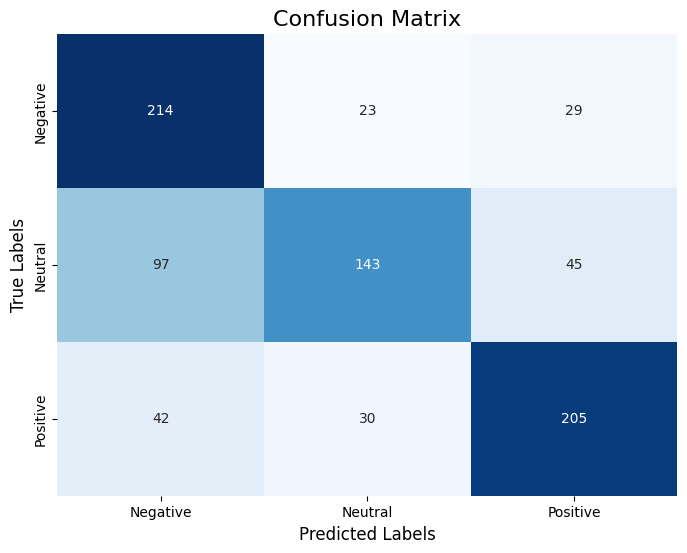

In [ ]:
cm=confusion_matrix(y_test_classes,y_pred_classes)
class_labels=le.classes_
plot_confusion_matrix(cm,class_labels)

In [ ]:
print(classification_report(y_test_classes,y_pred_classes))

              precision    recall  f1-score   support

           0       0.61      0.80      0.69       266
           1       0.73      0.50      0.59       285
           2       0.73      0.74      0.74       277

    accuracy                           0.68       828
   macro avg       0.69      0.68      0.67       828
weighted avg       0.69      0.68      0.67       828



In [ ]:
data = np.load("/content/MyDrive/MyDrive/Twitter sentiment analysis processed data/train_test_split.npz")


x_train = data["x_train"]
x_test = data["x_test"]
y_train = data["y_train"]
y_test = data["y_test"]
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (61121, 26)
y_train shape: (61121, 3)
x_test shape: (828, 26)
y_test shape: (828, 3)


In [ ]:
type(x_train)

numpy.ndarray

## Adding Global Average pooling 1D after Bidirectional LSTM

In [ ]:
dep_model4=Sequential([
    Embedding(input_dim=vocab_size,
                             output_dim=100,
                             input_length=26,
                             weights=[loaded_embedding_matrix],
                             trainable=True),
    Bidirectional(LSTM(64, dropout=0.3, return_sequences=True, recurrent_dropout=0.3, kernel_regularizer=l2(0.001))),
    GlobalAveragePooling1D(),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(3, activation='softmax')
])
opt=tf.keras.optimizers.AdamW(learning_rate=0.001,weight_decay=0.0001)
dep_model4.compile(loss='categorical_crossentropy',
                   optimizer=opt,
                   metrics=['accuracy'])
dep_model4.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)             │ ?                           │       2,486,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_18 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,486,000 (9.48 MB)

 Trainable params: 2,486,000 (9.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True),
           tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6)]
history4=dep_model4.fit(x_train,y_train,
               epochs=20,
               batch_size=32,
               validation_data=(x_test,y_test),
               callbacks=callbacks)

Epoch 1/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 116s 57ms/step - accuracy: 0.5390 - loss: 1.2337 - val_accuracy: 0.8913 - val_loss: 0.4303 - learning_rate: 0.0010
Epoch 2/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 142s 57ms/step - accuracy: 0.8151 - loss: 0.5391 - val_accuracy: 0.9287 - val_loss: 0.2668 - learning_rate: 0.0010
Epoch 3/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 142s 57ms/step - accuracy: 0.8557 - loss: 0.4109 - val_accuracy: 0.9444 - val_loss: 0.2079 - learning_rate: 0.0010
Epoch 4/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 141s 57ms/step - accuracy: 0.8820 - loss: 0.3424 - val_accuracy: 0.9517 - val_loss: 0.1916 - learning_rate: 0.0010
Epoch 5/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 139s 55ms/step - accuracy: 0.8930 - loss: 0.3052 - val_accuracy: 0.9589 - val_loss: 0.1707 - learning_rate: 0.0010
Epoch 6/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 145s 56ms/step - accuracy: 0.9039 - loss: 0.2770 - val_accuracy: 0.9601 - val_loss: 0.1627 - learning_rate: 0.0010
Epoch 7/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 140s 56ms/step -

In [ ]:
dep_model4.save("dep_model4.h5")

In [ ]:
from tensorflow.keras.models import load_model

# Load the model from HDF5 file
model = load_model("dep_model4.h5")


In [ ]:
model.evaluate(x_train,y_train),model.evaluate(x_test,y_test)

1911/1911 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9586 - loss: 0.1051
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9760 - loss: 0.0971


([0.10680194944143295, 0.9574123620986938],
 [0.12642566859722137, 0.9685990214347839])

In [ ]:
y_pred=model.predict(x_test)
y_pred

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step


array([[7.24186248e-05, 9.99898493e-01, 2.89794534e-05],
       [9.99876976e-01, 1.10766247e-04, 1.23748105e-05],
       [9.99953210e-01, 4.02096448e-05, 6.50015454e-06],
       ...,
       [1.23036498e-05, 7.54948851e-05, 9.99912143e-01],
       [1.76832196e-04, 5.97652433e-05, 9.99763429e-01],
       [2.81112771e-05, 9.99971271e-01, 6.28432588e-07]], dtype=float32)

In [ ]:
y_pred_classes=np.argmax(y_pred,axis=1)
y_pred_classes[:10]

array([1, 0, 0, 1, 0, 2, 2, 2, 0, 2])

In [ ]:
y_test_classes=np.argmax(y_test,axis=1)
y_test_classes[:10]

array([1, 0, 0, 1, 0, 2, 2, 2, 0, 2])

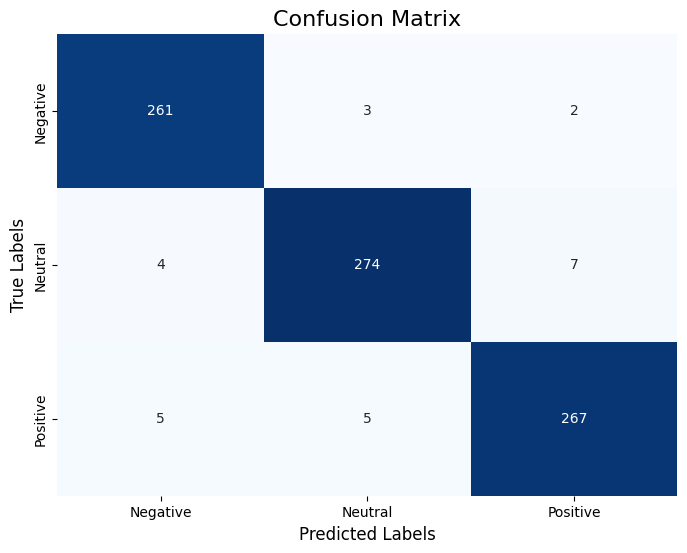

In [ ]:
cm=confusion_matrix(y_test_classes,y_pred_classes)
class_labels=le.classes_
plot_confusion_matrix(cm,class_labels)

In [ ]:
print(classification_report(y_test_classes,y_pred_classes))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       266
           1       0.97      0.96      0.97       285
           2       0.97      0.96      0.97       277

    accuracy                           0.97       828
   macro avg       0.97      0.97      0.97       828
weighted avg       0.97      0.97      0.97       828



In [ ]:
import pickle

# Load preprocessing objects (e.g., tokenizer)
path='/content/MyDrive/MyDrive/Twitter sentiment analysis processed data/text_preprocessing.pkl'
with open(path, "rb") as f:
    preprocessing_pipeline = pickle.load(f)


In [ ]:
print(type(preprocessing_pipeline))  # Check the data type
print(preprocessing_pipeline)  # Print details

<class 'function'>
<function clean_text at 0x7966bc9bb560>


In [ ]:
import pickle

tokenizer_path = "/content/MyDrive/MyDrive/Twitter sentiment analysis processed data/tokenizer.pkl"

with open(tokenizer_path, "rb") as f:
    tokenizer = pickle.load(f)

print(type(tokenizer))


<class 'keras.src.legacy.preprocessing.text.Tokenizer'>


In [ ]:
from nltk.tokenize import TweetTokenizer


donot_remove = {'am','not', 'have', 'has', 'must', 'should', 'had', 'might','never','was'}
stop_words = set(stopwords.words('english')) - donot_remove


tokenizer = TweetTokenizer(preserve_case=False, strip_handles=False, reduce_len=True)

In [ ]:
num_words = 20000
oov_token = "<OOV>"

tokenizer1 = Tokenizer(num_words = num_words,oov_token=oov_token)
tokenizer1.fit_on_texts(train_texts)

In [ ]:
def predict_sentiment(custom_tweet, preprocessing_pipeline, tokenizer, model, max_length=26):
    """
    Predicts the sentiment of a given tweet.

    Parameters:
    - custom_tweet (str): The input tweet to analyze.
    - preprocessing_pipeline (function): A function for text preprocessing.
    - tokenizer (Tokenizer): The trained tokenizer for text-to-sequence conversion.
    - model (tf.keras.Model): The trained sentiment analysis model.
    - max_length (int): The maximum sequence length for padding (default: 26).

    Returns:
    - str: The predicted sentiment ("Negative", "Neutral", or "Positive").
    """
    # Preprocess the tweet
    cleaned_tweet = preprocessing_pipeline(custom_tweet)

    # Convert text to sequence using the loaded tokenizer
    custom_tweet_seq = tokenizer.texts_to_sequences([cleaned_tweet])

    # Pad the sequence
    custom_tweet_padded = tf.keras.preprocessing.sequence.pad_sequences(custom_tweet_seq, maxlen=max_length,padding='post',truncating='post')

    # Make Prediction
    prediction = model.predict(custom_tweet_padded)

    # Convert Prediction to Sentiment Label
    sentiment_labels = ["Negative", "Neutral", "Positive"]
    predicted_class = sentiment_labels[np.argmax(prediction)]

    # Print results
    print("Cleaned Tweet:", cleaned_tweet)
    print("Tokenized Sequence:", custom_tweet_seq)
    print("Padded Sequence:", custom_tweet_padded)
    print("Prediction Probabilities:", prediction)
    print("Predicted Sentiment:", predicted_class)

    return predicted_class



In [ ]:
tweet = "I love this product!"
predicted_sentiment = predict_sentiment(tweet, preprocessing_pipeline, tokenizer1, model)
print(f"Final Predicted Sentiment: {predicted_sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Cleaned Tweet: ['love', 'product']
Tokenized Sequence: [[7, 747]]
Padded Sequence: [[  7 747   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]]
Prediction Probabilities: [[0.05756181 0.12821983 0.8142184 ]]
Predicted Sentiment: Positive
Final Predicted Sentiment: Positive


In [ ]:
print(tokenizer1.word_index)  # Check if words are indexed correctly


{'<OOV>': 1, 'not': 2, 'have': 3, 'game': 4, 'am': 5, 'was': 6, 'love': 7, 'like': 8, 'anger': 9, 'get': 10, 'play': 11, 'one': 12, 'good': 13, 'new': 14, 'has': 15, 'really': 16, 'time': 17, 'fuck': 18, 'going': 19, 'people': 20, 'unk': 21, 'surprise': 22, 'still': 23, 'got': 24, 'games': 25, 'best': 26, 'playing': 27, 'us': 28, 'see': 29, 'would': 30, 'dead': 31, 'great': 32, 'even': 33, 'please': 34, 'fucking': 35, 'go': 36, 'red': 37, 'had': 38, 'back': 39, 'xbox': 40, 'rhandlerr': 41, 'much': 42, 'home': 43, 'know': 44, 'want': 45, 'fix': 46, 'first': 47, 'pride': 48, 'make': 49, 'fun': 50, 'day': 51, 'today': 52, 'x': 53, 'excitement': 54, 'ever': 55, 'also': 56, 'fear': 57, 'bad': 58, 'redemption': 59, 'right': 60, 'wait': 61, 'thank': 62, 'every': 63, 'never': 64, 'world': 65, 'year': 66, 'call': 67, 'video': 68, 'depot': 69, 'gta': 70, 'thanks': 71, 'series': 72, 'pubg': 73, 'getting': 74, 'amazing': 75, 'legends': 76, 'work': 77, 'think': 78, 'played': 79, 'last': 80, 'v': 81

In [ ]:
train[train['tweet'].str.contains('laugh', case=False, na=False)]['sentiment'].value_counts()

,count
sentiment,
2,47
1,42
0,38


In [ ]:
train[(train['tweet'].str.contains('laugh', case=False, na=False)) & (train['sentiment'] == 0)].head(10)


,id,entity,sentiment,tweet,processed_text
1296,2657,Borderlands,0,"Look, I love Borderlands 3 to death, but what ...","[look, love, death, want, know, moron, gearbox..."
1297,2657,Borderlands,0,"See, I love Borderlands 3 to death, but what I...","[see, love, death, want, know, moron, gearbox,..."
1300,2657,Borderlands,0,"Look, technically I love Borderlands 3 going t...","[look, technically, love, going, death, actual..."
1301,2657,Borderlands,0,"Look, girls love Borderlands 3 to death, like ...","[look, girls, love, death, like, people, care,..."
2455,1702,CallOfDutyBlackopsColdWar,0,Why is this happening? It literally punishes y...,"[happening, literally, punishes, going, slaugh..."
5068,239,Amazon,0,I mean really what I'm saying with this post i...,"[mean, really, am, saying, post, evil, researc..."
6966,9438,Overwatch,0,ever since i was called funny ive never be abl...,"[ever, since, was, called, funny, have, never,..."
10485,8657,NBA2K,0,@ Ronnie2K @ NBA2K @ Mitchel _ Inkrott I was j...,"[ronniek, mitchel, inkrott, was, win, fourth, ..."
21426,951,AssassinsCreed,0,which assassins creed game was it where ubisof...,"[assassins, creed, game, was, ubisoft, release..."
21427,951,AssassinsCreed,0,which murderous faith game was it in which ubi...,"[murderous, faith, game, was, ubisoft, release..."


In [ ]:
import numpy as np

word = "laugh"
if word in word_index:
    word_vec = loaded_embedding_matrix[word_index[word]]
    print(f"Embedding for '{word}':", word_vec)
else:
    print(f"'{word}' not found in vocabulary!")


Embedding for 'laugh': [-1.38970206e-02  8.75013089e-02  1.16978577e-01 -2.15357073e-03
  1.53837556e-03 -3.71939508e-02  5.35469455e-02  1.66817598e-02
 -9.90112117e-02  1.05059266e-01 -9.94314804e-02 -8.00342941e-02
 -7.01480612e-01  1.12462700e-02 -8.66328749e-02 -2.63586391e-02
 -3.02154324e-02 -1.10055886e-02  2.96106271e-03  3.59331653e-02
  3.59858919e-02  2.44294643e-03 -1.30349414e-02 -5.48077287e-02
  4.57697737e-02  1.06518546e-01 -1.08905201e-02 -5.60452555e-02
 -1.15426243e-01 -6.06572814e-02 -7.83610067e-03 -7.57432861e-02
 -9.66261147e-02  2.94167790e-02 -2.29096984e-02 -2.99502491e-02
  2.75791026e-02 -4.03947622e-02  2.00934809e-02 -6.04665351e-02
 -1.07315651e-02 -5.84257031e-02  3.12234415e-02  6.87415065e-04
 -1.68802602e-02  1.41591031e-03  1.17111940e-01  9.68680324e-02
  1.12419279e-02  2.74798542e-02 -4.82370675e-02  4.92171616e-02
  5.99919961e-03 -9.20466578e-02  2.04191437e-01 -1.05921498e-01
 -6.14869487e-02  1.29014187e-01  9.39029410e-02  5.10036619e-02
  

In [ ]:
tweets=["I didn't like it ",
        "I was a boring movie",
        'What a nice girl',
        'She is a positive girl',
        'fucked up',
        'you suck',
        'I got a great feeling about this',
        'I am beautiful',
        'She is a woman',
        'I am a bastard lol!',
        'I am laughing',
        "I love to laugh, it's the best feeling!",
        'He is showing off his abs']
for tweet in tweets:
  predicted_sentiment = predict_sentiment(tweet, preprocessing_pipeline, tokenizer1, model)
  print(f"Final Predicted Sentiment: {predicted_sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Cleaned Tweet: ['not', 'like']
Tokenized Sequence: [[2, 8]]
Padded Sequence: [[2 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
Prediction Probabilities: [[0.566203   0.14697713 0.2868198 ]]
Predicted Sentiment: Negative
Final Predicted Sentiment: Negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Cleaned Tweet: ['boring', 'movie']
Tokenized Sequence: [[689, 528]]
Padded Sequence: [[689 528   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]]
Prediction Probabilities: [[9.9801314e-01 1.6929540e-03 2.9391702e-04]]
Predicted Sentiment: Negative
Final Predicted Sentiment: Negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Cleaned Tweet: ['nice', 'girl']
Tokenized Sequence: [[121, 651]]
Padded Sequence: [[121 651   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]]
Prediction Probabilities: [[0.02120117 0.02078162 0.9580172 ]]
Predicted Sentiment: Positive
Final 

In [ ]:
import collections

label_counts = collections.Counter(y_train.argmax(axis=1))
print(label_counts)


Counter({0: 22358, 2: 20655, 1: 18108})


## Adding MaxPool1D instead of Global average pooling

In [ ]:
x_train = np.array(x_train, dtype=np.int32)
x_test=np.array(x_test,dtype=np.int32)
y_train = np.array(y_train, dtype=np.float32)
y_test=np.array(y_test,dtype=np.float32)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((61121, 26), (828, 26), (61121, 3), (828, 3))

In [ ]:
dep_model5=Sequential([
    Embedding(input_dim=vocab_size,
                             output_dim=100,
                             input_length=26,
                             weights=[loaded_embedding_matrix],
                             trainable=True),
    Bidirectional(LSTM(64, dropout=0.3, return_sequences=True, recurrent_dropout=0.3, kernel_regularizer=l2(0.001))),
    MaxPooling1D(pool_size=2),
    Flatten(),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(3, activation='softmax')
])
opt=tf.keras.optimizers.AdamW(learning_rate=0.001,weight_decay=0.0001)
dep_model5.compile(loss='categorical_crossentropy',
                   optimizer=opt,
                   metrics=['accuracy'])
dep_model5.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ ?                           │       2,486,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,486,000 (9.48 MB)

 Trainable params: 2,486,000 (9.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True),
           tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6)]
history5=dep_model5.fit(x_train,y_train,
                        epochs=20,
                        validation_data=(x_test,y_test),
                        batch_size=32,
                        callbacks=callbacks)

Epoch 1/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 330s 166ms/step - accuracy: 0.5808 - loss: 1.2189 - val_accuracy: 0.8998 - val_loss: 0.3924 - learning_rate: 0.0010
Epoch 2/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 251s 131ms/step - accuracy: 0.8434 - loss: 0.4842 - val_accuracy: 0.9336 - val_loss: 0.2615 - learning_rate: 0.0010
Epoch 3/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 258s 129ms/step - accuracy: 0.8854 - loss: 0.3571 - val_accuracy: 0.9565 - val_loss: 0.2018 - learning_rate: 0.0010
Epoch 4/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 244s 128ms/step - accuracy: 0.9039 - loss: 0.3051 - val_accuracy: 0.9601 - val_loss: 0.1968 - learning_rate: 0.0010
Epoch 5/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 245s 128ms/step - accuracy: 0.9121 - loss: 0.2794 - val_accuracy: 0.9626 - val_loss: 0.1755 - learning_rate: 0.0010
Epoch 6/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 238s 125ms/step - accuracy: 0.9190 - loss: 0.2588 - val_accuracy: 0.9577 - val_loss: 0.1708 - learning_rate: 0.0010
Epoch 7/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 241s 126ms

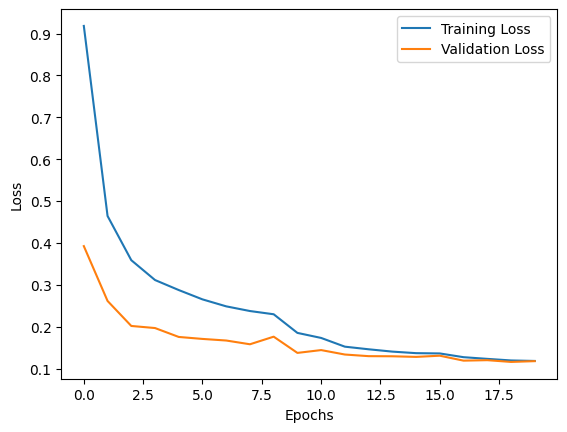

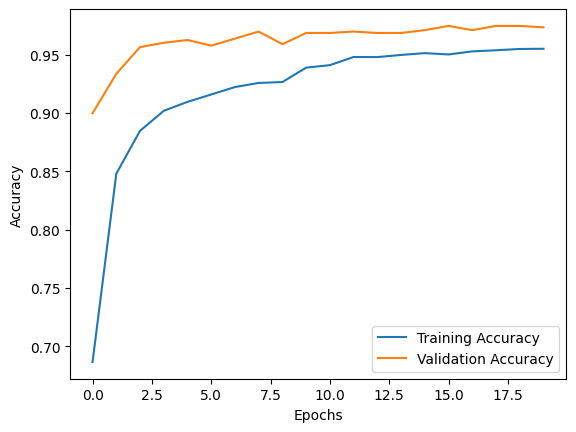

In [ ]:
plot_loss_acc_curves(history5)

In [ ]:
dep_model5.evaluate(x_train,y_train),dep_model5.evaluate(x_test,y_test)

1911/1911 ━━━━━━━━━━━━━━━━━━━━ 35s 18ms/step - accuracy: 0.9669 - loss: 0.0853
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9752 - loss: 0.1071


([0.08703883737325668, 0.9653638005256653],
 [0.1158754751086235, 0.9746376872062683])

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step


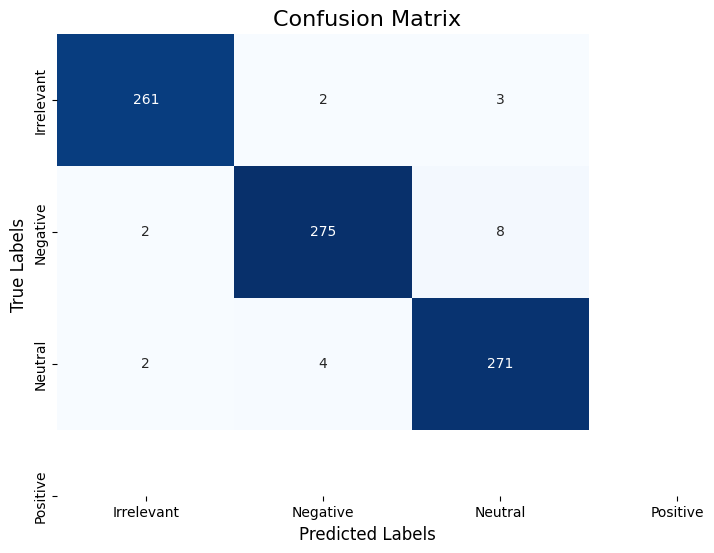

In [ ]:
y_test_classes=np.argmax(y_test,axis=1)
y_pred_classes=np.argmax(dep_model5.predict(x_test),axis=1)
cm=confusion_matrix(y_test_classes,y_pred_classes)
class_labels=le.classes_
plot_confusion_matrix(cm,class_labels)

In [ ]:
tweets=["I didn't like it ",
        "I was a boring movie",
        'What a nice girl',
        'She is a positive girl',
        'fucked up',
        'you suck',
        'I got a great feeling about this',
        'I am beautiful',
        'She is a woman',
        'I am a bastard lol!',
        'I am laughing',
        'You are truely blessed',
        "I love to laugh, it's the best feeling!",
        'He is showing off his abs']
for tweet in tweets:
  predicted_sentiment = predict_sentiment(tweet, preprocessing_pipeline, tokenizer1, dep_model5)
  print(f"Final Predicted Sentiment: {predicted_sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Cleaned Tweet: ['not', 'like']
Tokenized Sequence: [[2, 8]]
Padded Sequence: [[2 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
Prediction Probabilities: [[0.6887872  0.07142536 0.23978743]]
Predicted Sentiment: Negative
Final Predicted Sentiment: Negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Cleaned Tweet: ['boring', 'movie']
Tokenized Sequence: [[689, 528]]
Padded Sequence: [[689 528   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]]
Prediction Probabilities: [[9.9979526e-01 1.0567679e-04 9.9088284e-05]]
Predicted Sentiment: Negative
Final Predicted Sentiment: Negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Cleaned Tweet: ['nice', 'girl']
Tokenized Sequence: [[121, 651]]
Padded Sequence: [[121 651   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]]
Prediction Probabilities: [[1.16071475e-04 5.29306848e-03 9.94590878e-01]]
Predicted Sentiment: Pos

## Stacking two Bilstm layers

In [ ]:
dep_model6=Sequential([
    Embedding(input_dim=vocab_size,
                             output_dim=100,
                             input_length=26,
                             weights=[loaded_embedding_matrix],
                             trainable=True),
    Bidirectional(LSTM(64, dropout=0.3, return_sequences=True, recurrent_dropout=0.3, kernel_regularizer=l2(0.001))),
    Bidirectional(LSTM(32, dropout=0.3, return_sequences=False, recurrent_dropout=0.3, kernel_regularizer=l2(0.001))),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(3, activation='softmax')
])
opt=tf.keras.optimizers.AdamW(learning_rate=0.001,weight_decay=0.0001)
dep_model6.compile(loss='categorical_crossentropy',
                   optimizer=opt,
                   metrics=['accuracy'])
dep_model6.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)              │ ?                           │       2,486,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,486,000 (9.48 MB)

 Trainable params: 2,486,000 (9.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True),
           tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6)]
history6=dep_model6.fit(x_train,y_train,
                        epochs=20,
                        validation_data=(x_test,y_test),
                        batch_size=32,
                        callbacks=callbacks)

Epoch 1/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 365s 179ms/step - accuracy: 0.5354 - loss: 1.3903 - val_accuracy: 0.8841 - val_loss: 0.4669 - learning_rate: 0.0010
Epoch 2/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 339s 177ms/step - accuracy: 0.8083 - loss: 0.5889 - val_accuracy: 0.9336 - val_loss: 0.2626 - learning_rate: 0.0010
Epoch 3/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 338s 177ms/step - accuracy: 0.8630 - loss: 0.4180 - val_accuracy: 0.9505 - val_loss: 0.2110 - learning_rate: 0.0010
Epoch 4/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 346s 181ms/step - accuracy: 0.8844 - loss: 0.3535 - val_accuracy: 0.9444 - val_loss: 0.1975 - learning_rate: 0.0010
Epoch 5/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 373s 177ms/step - accuracy: 0.8970 - loss: 0.3103 - val_accuracy: 0.9614 - val_loss: 0.1511 - learning_rate: 0.0010
Epoch 6/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 335s 175ms/step - accuracy: 0.9049 - loss: 0.2845 - val_accuracy: 0.9589 - val_loss: 0.1498 - learning_rate: 0.0010
Epoch 7/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 348s 182ms

In [ ]:
dep_model6.evaluate(x_train,y_train),dep_model5.evaluate(x_test,y_test)

1911/1911 ━━━━━━━━━━━━━━━━━━━━ 89s 47ms/step - accuracy: 0.9526 - loss: 0.1301
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9752 - loss: 0.1071


([0.13302823901176453, 0.9510806202888489],
 [0.1158754751086235, 0.9746376872062683])

26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step


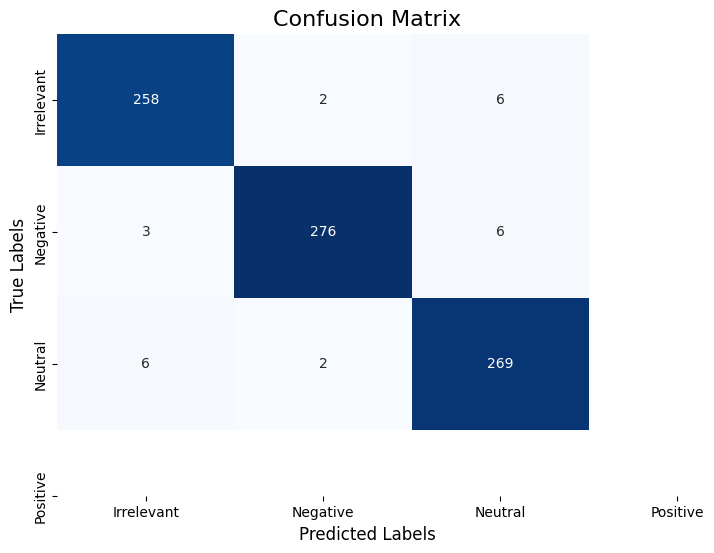

In [ ]:
y_test_classes=np.argmax(y_test,axis=1)
y_pred_classes=np.argmax(dep_model6.predict(x_test),axis=1)
cm=confusion_matrix(y_test_classes,y_pred_classes)
class_labels=le.classes_
plot_confusion_matrix(cm,class_labels)

In [ ]:
tweets=["I didn't like it ",
        "I was a boring movie",
        'What a nice girl',
        'She is a positive girl',
        'fucked up',
        'you suck',
        'I got a great feeling about this',
        'I am beautiful',
        'She is a woman',
        'I am a bastard lol!',
        'Mind your language',
        'I am laughing',
        'You are truely blessed',
        "I love to laugh, it's the best feeling!",
        'He is showing off his abs']
for tweet in tweets:
  predicted_sentiment = predict_sentiment(tweet, preprocessing_pipeline, tokenizer1, dep_model6)
  print(f"Final Predicted Sentiment: {predicted_sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Cleaned Tweet: ['not', 'like']
Tokenized Sequence: [[2, 8]]
Padded Sequence: [[2 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
Prediction Probabilities: [[0.60804486 0.1706107  0.22134447]]
Predicted Sentiment: Negative
Final Predicted Sentiment: Negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Cleaned Tweet: ['boring', 'movie']
Tokenized Sequence: [[689, 528]]
Padded Sequence: [[689 528   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]]
Prediction Probabilities: [[0.9976046  0.00117889 0.0012165 ]]
Predicted Sentiment: Negative
Final Predicted Sentiment: Negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Cleaned Tweet: ['nice', 'girl']
Tokenized Sequence: [[121, 651]]
Padded Sequence: [[121 651   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]]
Prediction Probabilities: [[0.00509234 0.01088729 0.98402035]]
Predicted Sentiment: Positive
Final Predict

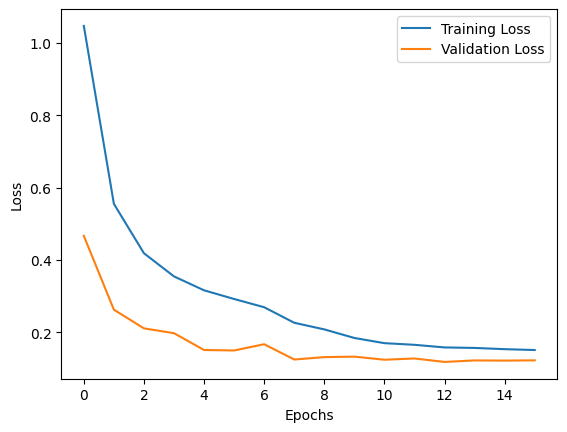

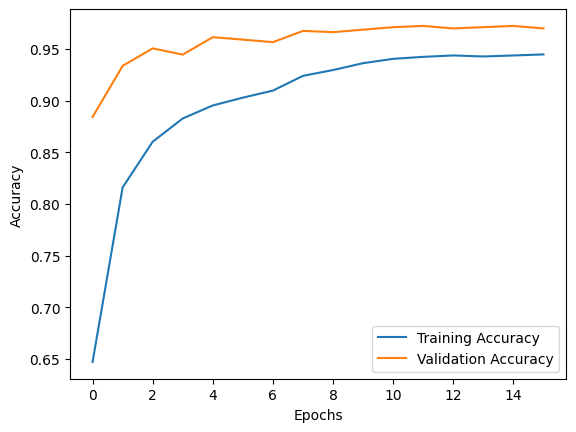

In [ ]:
plot_loss_acc_curves(history6)

## Implementing bilstm + attention

In [ ]:
from keras.layers import Attention,Layer,Input
import tensorflow.keras.backend as K
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
    def build(self,input_shape):
      self.W=self.add_weight(name='attention_weights',
                             shape=(input_shape[-1],1),
                             initializer='random_normal',
                             trainable=True,
                             )
      self.b=self.add_weight(name='attention_bias',
                             shape=(1,),
                             initializer='zeros',
                             trainable=True)
      super(AttentionLayer,self).build(input_shape)
    def call(self,inputs):
      score=K.tanh(K.dot(inputs,self.W)+self.b)
      attention_weights=K.softmax(score,axis=1)
      context_vector=inputs*attention_weights
      return K.sum(context_vector,axis=1)

In [ ]:
inputs=Input(shape=(26,))
x=Embedding(input_dim=vocab_size,
            output_dim=100,
            weights=[loaded_embedding_matrix],
            trainable=True)(inputs)
x=Bidirectional(LSTM(units=64,return_sequences=True,dropout=0.3,recurrent_dropout=0.3))(x)
x=AttentionLayer()(x)
x=Dropout(0.3)(x)
x=Dense(64,activation='relu')(x)
output=Dense(3,activation='softmax')(x)
dep_model7=tf.keras.models.Model(inputs=inputs,outputs=output)

opt=tf.keras.optimizers.AdamW(learning_rate=0.001,weight_decay=0.0001)
dep_model7.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
dep_model7.summary()

In [ ]:
callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=1,factor=0.5,min_lr=1e-6)
]
dep_model7.fit(x_train,y_train,
               epochs=20,
               validation_data=(x_test,y_test),
               batch_size=32,
               callbacks=callbacks)

Epoch 1/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 255s 128ms/step - accuracy: 0.5998 - loss: 0.8533 - val_accuracy: 0.9118 - val_loss: 0.2846 - learning_rate: 0.0010
Epoch 2/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 242s 126ms/step - accuracy: 0.8518 - loss: 0.3863 - val_accuracy: 0.9529 - val_loss: 0.1604 - learning_rate: 0.0010
Epoch 3/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 268s 129ms/step - accuracy: 0.8983 - loss: 0.2581 - val_accuracy: 0.9674 - val_loss: 0.1278 - learning_rate: 0.0010
Epoch 4/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 255s 126ms/step - accuracy: 0.9172 - loss: 0.2039 - val_accuracy: 0.9626 - val_loss: 0.1407 - learning_rate: 0.0010
Epoch 5/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 242s 127ms/step - accuracy: 0.9310 - loss: 0.1648 - val_accuracy: 0.9686 - val_loss: 0.1386 - learning_rate: 5.0000e-04
Epoch 6/20
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 263s 127ms/step - accuracy: 0.9398 - loss: 0.1403 - val_accuracy: 0.9722 - val_loss: 0.1453 - learning_rate: 2.5000e-04


In [ ]:
dep_model7.evaluate(x_train,y_train),dep_model7.evaluate(x_test,y_test)

## Using BERT

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [ ]:
from transformers import BertTokenizer,BertForSequenceClassification,Trainer, TrainingArguments,default_data_collator,AutoModelForSequenceClassification,AutoTokenizer,EarlyStoppingCallback
import html
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from datasets import Dataset
from peft import LoraConfig, get_peft_model
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
csv_file = os.path.join(path, "twitter_training.csv")
train_data = pd.read_csv(csv_file,header=None)
csv_file=os.path.join(path,'twitter_validation.csv')
test_data=pd.read_csv(csv_file,header=None)

train_data.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
train_data.columns=['tweet_id','state','sentiment','tweet']
test_data.columns=['tweet_id','state','sentiment','tweet']

In [ ]:
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
train_data1=train_data[(train_data['sentiment'] != 'Irrelevant')]
np.unique(train_data1['sentiment'])

array(['Negative', 'Neutral', 'Positive'], dtype=object)

In [ ]:
def data_preprocessing(tweet):
  if isinstance(tweet,str):
    tweet=html.unescape(tweet)
    tweet=re.sub(r'\s+',' ',tweet).strip()
    tweet=emoji.demojize(tweet,language='en')
  return tweet

In [ ]:
train_data1['tweet_processed']=train_data1['tweet'].apply(data_preprocessing)

<ipython-input-11-64a5e3fb920e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data1['tweet_processed']=train_data1['tweet'].apply(data_preprocessing)


In [ ]:
train_data1['tweet_processed']

,tweet_processed
0,im getting on borderlands and i will murder yo...
1,I am coming to the borders and I will kill you...
2,im getting on borderlands and i will kill you ...
3,im coming on borderlands and i will murder you...
4,im getting on borderlands 2 and i will murder ...
...,...
74677,Just realized that the Windows partition of my...
74678,Just realized that my Mac window partition is ...
74679,Just realized the windows partition of my Mac ...
74680,Just realized between the windows partition of...


In [ ]:
x=list(train_data1['tweet_processed'].astype(str))
y=list(train_data1['sentiment'])

In [ ]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(y)

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,labels,test_size=0.2,random_state=42)

In [ ]:
train_encodings=tokenizer(x_train,truncation=True,padding=True,return_tensors='pt')
train_encodings

{'input_ids': tensor([[  101, 21864,  2243,  ...,     0,     0,     0],
        [  101,  1030,  5745,  ...,     0,     0,     0],
        [  101,  2107, 10231,  ...,     0,     0,     0],
        ...,
        [  101,  2197,  2095,  ...,     0,     0,     0],
        [  101,  2792,  2531,  ...,     0,     0,     0],
        [  101,  1030,  3533,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [ ]:
test_encodings=tokenizer(x_test,truncation=True,padding=True,return_tensors='pt')
test_encodings

{'input_ids': tensor([[  101,  7987, 27225,  ...,     0,     0,     0],
        [  101,  1008,  2033,  ...,     0,     0,     0],
        [  101,  1030, 10098,  ...,     0,     0,     0],
        ...,
        [  101,  2209,  2070,  ...,     0,     0,     0],
        [  101,  1049,  2061,  ...,     0,     0,     0],
        [  101,  1012,  1058,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [ ]:
y_train_tensor = torch.tensor(y_train.tolist())
y_test_tensor = torch.tensor(y_test.tolist())
train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'],
                                   'attention_mask': train_encodings['attention_mask'],
                                   'labels': y_train_tensor})

test_dataset = Dataset.from_dict({'input_ids': test_encodings['input_ids'],
                                  'attention_mask': test_encodings['attention_mask'],
                                  'labels': y_test_tensor})

In [ ]:
"""dataset = tf.data.Dataset.from_tensor_slices((
    dict(encodings),
    labels
))
batch_size=16
train_dataset=dataset.shuffle(len(x)).batch(batch_size)"""

In [ ]:
"""from torch.utils.data import Dataset
import torch

class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])

        return item

    def __len__(self):
        return len(self.labels)"""


In [ ]:
"""train_dataset=TweetDataset(train_encodings,labels)"""

In [ ]:
model=BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=3)
lora_config=LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=['query','key','value'],
    lora_dropout=0.1,
    bias='none',
    task_type='SEQ_CLS'
)

model=get_peft_model(model,lora_config)
model.print_trainable_parameters()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 444,675 || all params: 109,929,222 || trainable%: 0.4045


In [ ]:
class CustomTrainer(Trainer):
    def get_train_dataloader(self,train_dataset=None):
        return train_dataloader

    def get_eval_dataloader(self,eval_dataset=None):
        return eval_dataloader

In [ ]:
def compute_metrics(eval_pred):
      logits, labels = eval_pred
      preds = np.argmax(logits, axis=1)
      acc = accuracy_score(labels, preds)
      return {"accuracy": acc}

In [ ]:
def predict_sentiment_hf(tweet_text, tokenizer, model):
    inputs = tokenizer(tweet_text, return_tensors="pt", truncation=True, padding=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items() if k != "token_type_ids"}  # Remove token_type_ids for DistilBERT
    model.eval()

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()

    labels = ["Negative", "Neutral", "Positive"]
    predicted = labels[np.argmax(probs)]

    print(f"Tweet: {tweet_text}")
    print(f"Probabilities: {probs}")
    print(f"Predicted Sentiment: {predicted}")

In [ ]:
train_dataloader = DataLoader(
    train_dataset, batch_size=8, num_workers=2, collate_fn=default_data_collator
)

eval_dataloader = DataLoader(
    test_dataset, batch_size=8, num_workers=2, collate_fn=default_data_collator
)


training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    warmup_steps=100,
    num_train_epochs=5,
    logging_dir="./logs",
    learning_rate=2e-5,
    report_to="none",
    fp16=True,
    logging_strategy='epoch',
    eval_strategy='epoch',
    save_strategy='epoch',
    dataloader_num_workers=2,

)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss
1,0.879200,0.772761
2,0.764500,0.737015
3,0.733600,0.721072
4,0.715600,0.709678
5,0.707500,0.705491


TrainOutput(global_step=15425, training_loss=0.7600954245593599, metrics={'train_runtime': 3644.5987, 'train_samples_per_second': 67.707, 'train_steps_per_second': 4.232, 'total_flos': 4.01528246895279e+16, 'train_loss': 0.7600954245593599, 'epoch': 5.0})

In [ ]:
trainer.save_model("/content/MyDrive/MyDrive/twitter_sentiment_analysis/bert_model")
tokenizer.save_pretrained("/content/MyDrive/MyDrive/twitter_sentiment_analysis/bert_tokenizer")

('/content/MyDrive/MyDrive/twitter_sentiment_analysis/bert_tokenizer/tokenizer_config.json',
 '/content/MyDrive/MyDrive/twitter_sentiment_analysis/bert_tokenizer/special_tokens_map.json',
 '/content/MyDrive/MyDrive/twitter_sentiment_analysis/bert_tokenizer/vocab.txt',
 '/content/MyDrive/MyDrive/twitter_sentiment_analysis/bert_tokenizer/added_tokens.json')

In [ ]:
loaded_tokenizer = BertTokenizer.from_pretrained('/content/MyDrive/MyDrive/twitter_sentiment_analysis/bert_tokenizer')

loaded_model = BertForSequenceClassification.from_pretrained(
    '/content/MyDrive/MyDrive/twitter_sentiment_analysis/bert_model',
    num_labels=3,
    ignore_mismatched_sizes=True
)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
results=trainer.evaluate()
results

{'eval_loss': 0.7054909467697144,
 'eval_runtime': 55.18,
 'eval_samples_per_second': 223.614,
 'eval_steps_per_second': 27.963,
 'epoch': 5.0}

In [ ]:
import numpy as np
tweets=["I didn't like it ",
        "It was a boring movie",
        'What a nice girl',
        'She is a positive girl',
        'fucked up',
        'you suck',
        'I got a great feeling about this',
        'I am beautiful',
        'She is a woman',
        'I am a bastard lol!',
        'Mind your language',
        'That was hillerious',
        'I am laughing',
        'I am going to kerala today',
        'You are truely blessed',
        "I love to laugh, it's the best feeling!",
        'He is showing off his abs',
        "what I'm saying is that you are literally the Monday of my life.",
        "Life's good, you should get one."]
for tweet in tweets:
  predict_sentiment_hf(tweet, loaded_tokenizer, loaded_model)
  print('\n')

Tweet: I didn't like it 
Probabilities: [[0.8248629  0.07596234 0.09917483]]
Predicted Sentiment: Negative


Tweet: It was a boring movie
Probabilities: [[0.9056389  0.06442652 0.02993454]]
Predicted Sentiment: Negative


Tweet: What a nice girl
Probabilities: [[0.02752176 0.05334618 0.9191321 ]]
Predicted Sentiment: Positive


Tweet: She is a positive girl
Probabilities: [[0.03528066 0.08224075 0.88247865]]
Predicted Sentiment: Positive


Tweet: fucked up
Probabilities: [[0.88945323 0.06332126 0.04722546]]
Predicted Sentiment: Negative


Tweet: you suck
Probabilities: [[0.8646815  0.05813102 0.07718752]]
Predicted Sentiment: Negative


Tweet: I got a great feeling about this
Probabilities: [[0.02778593 0.04188987 0.93032426]]
Predicted Sentiment: Positive


Tweet: I am beautiful
Probabilities: [[0.02457857 0.04560364 0.9298178 ]]
Predicted Sentiment: Positive


Tweet: She is a woman
Probabilities: [[0.09616798 0.12460316 0.7792289 ]]
Predicted Sentiment: Positive


Tweet: I am a basta

In [ ]:
model.eval()
preds = []
true_labels = []

with torch.no_grad():
    for batch in eval_dataloader:
        input_ids = batch['input_ids'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)
        labels = batch['labels'].to(model.device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        preds.extend(predictions.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, preds)
report = classification_report(true_labels, preds)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Accuracy: 0.6901693816354648
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.80      0.74      4509
           1       0.68      0.50      0.58      3650
           2       0.69      0.74      0.72      4180

    accuracy                           0.69     12339
   macro avg       0.69      0.68      0.68     12339
weighted avg       0.69      0.69      0.68     12339



In [ ]:
def predict_sentiment_hf(tweet_text, tokenizer, model):
    inputs = tokenizer(tweet_text, return_tensors="pt", truncation=True, padding=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    model.eval()

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()

    labels = ["Negative", "Neutral", "Positive"]
    predicted = labels[np.argmax(probs)]

    print(f"Tweet: {tweet_text}")
    print(f"Probabilities: {probs}")
    print(f"Predicted Sentiment: {predicted}")

In [ ]:
import tweepy

api_key = '<api-key>'
api_key_secret = '<api-secret-key>'
bearer_token = '<bearer_token>'

client = tweepy.Client(bearer_token=bearer_token)

query = 'AI OR machine learning -is:retweet lang:en'
tweets = client.search_recent_tweets(
    query=query,
    max_results=10,
    tweet_fields=["lang"]
)

In [ ]:
for tweet in tweets.data:
    if tweet.lang == "en":
        print(tweet.text)

@MarioNawfal So who do they blame when the AI turns itself off before a crash?
RT @Somnia_Network: 🎙️ Join us on Monday, April 29 at 2PM UTC as we chat with @LootMogul, @qstnus, and @4UAICrypto about how social, identi…
@Fluxai_Ai Strong fundamentals here
RT @campnetworkxyz: AI is threatening ALL creative work.

This is why we built Camp, the Autonomous IP Layer 1 Blockchain.

But what does t…


In [ ]:
for tweet in tweets.data:
    if tweet.lang == "en":
        text = tweet.text
        predict_sentiment_hf(text, tokenizer, model)
        print('\n')

Tweet: @MarioNawfal So who do they blame when the AI turns itself off before a crash?
Probabilities: [[0.9291107  0.04603238 0.02485687]]
Predicted Sentiment: Negative


Tweet: RT @Somnia_Network: 🎙️ Join us on Monday, April 29 at 2PM UTC as we chat with @LootMogul, @qstnus, and @4UAICrypto about how social, identi…
Probabilities: [[0.14124554 0.66437036 0.19438407]]
Predicted Sentiment: Neutral


Tweet: @Fluxai_Ai Strong fundamentals here
Probabilities: [[0.1780149  0.17258008 0.64940506]]
Predicted Sentiment: Positive


Tweet: RT @campnetworkxyz: AI is threatening ALL creative work.

This is why we built Camp, the Autonomous IP Layer 1 Blockchain.

But what does t…
Probabilities: [[0.8872618  0.0824074  0.03033079]]
Predicted Sentiment: Negative




## DistilBert

In [ ]:
tokenizer1 = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model1 = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_encodings=tokenizer1(x_train,truncation=True,padding=True,return_tensors='pt')
test_encodings=tokenizer1(x_test,truncation=True,padding=True,return_tensors='pt')
train_encodings

{'input_ids': tensor([[  101, 21864,  2243,  ...,     0,     0,     0],
        [  101,  1030,  5745,  ...,     0,     0,     0],
        [  101,  2107, 10231,  ...,     0,     0,     0],
        ...,
        [  101,  2197,  2095,  ...,     0,     0,     0],
        [  101,  2792,  2531,  ...,     0,     0,     0],
        [  101,  1030,  3533,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [ ]:
y_train_tensor = torch.tensor(y_train.tolist())
y_test_tensor = torch.tensor(y_test.tolist())

train_dataset=Dataset.from_dict({'input_ids':train_encodings['input_ids'],
                                 'attention_mask':train_encodings['attention_mask'],
                                 'labels':y_train_tensor})
test_dataset=Dataset.from_dict({'input_ids':test_encodings['input_ids'],
                                'attention_mask':test_encodings['attention_mask'],
                                'labels':y_test_tensor})

In [ ]:
lora_config=LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules = ['q_lin', 'k_lin', 'v_lin'],
    lora_dropout=0.1,
    bias='none',
    task_type='SEQ_CLS'
)

model=get_peft_model(model1,lora_config)
model.print_trainable_parameters()

trainable params: 814,083 || all params: 67,769,862 || trainable%: 1.2012


In [ ]:
print("CUDA:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0))
print("TF32 supported:", torch.backends.cuda.matmul.allow_tf32)

CUDA: True
GPU: Tesla T4
TF32 supported: False


In [ ]:
train_dataloader = DataLoader(
    train_dataset, batch_size=8, num_workers=2, collate_fn=default_data_collator
)

eval_dataloader = DataLoader(
    test_dataset, batch_size=8, num_workers=2, collate_fn=default_data_collator
)


training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    warmup_steps=100,
    num_train_epochs=10,
    logging_dir="./logs",
    learning_rate=2e-5,
    report_to="none",
    fp16=True,
    logging_strategy='epoch',
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    dataloader_num_workers=2,
)

trainer = CustomTrainer(
    model=model1,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.815600,0.744756,0.681822
2,0.724000,0.710308,0.697625
3,0.690100,0.687290,0.707756
4,0.669100,0.671113,0.713996
5,0.649300,0.656771,0.719588
6,0.634600,0.646297,0.723884
7,0.624600,0.638782,0.728989
8,0.615900,0.632308,0.730853
9,0.605900,0.628445,0.732717
10,0.605900,0.627496,0.733366


TrainOutput(global_step=30850, training_loss=0.6634938066627837, metrics={'train_runtime': 3872.8947, 'train_samples_per_second': 127.432, 'train_steps_per_second': 7.966, 'total_flos': 4.098202421827501e+16, 'train_loss': 0.6634938066627837, 'epoch': 10.0})

In [ ]:
results=trainer.evaluate()
results

{'eval_loss': 0.6274963617324829,
 'eval_accuracy': 0.7333657508712214,
 'eval_runtime': 31.0566,
 'eval_samples_per_second': 397.307,
 'eval_steps_per_second': 49.683,
 'epoch': 10.0}

In [ ]:
train_metrics = trainer.evaluate(eval_dataset=train_dataset)
print("Train:", train_metrics)

val_metrics = trainer.evaluate(eval_dataset=test_dataset)
print("Validation:", val_metrics)


Train: {'eval_loss': 0.6274963617324829, 'eval_accuracy': 0.7333657508712214, 'eval_runtime': 33.364, 'eval_samples_per_second': 369.829, 'eval_steps_per_second': 46.247, 'epoch': 10.0}
Validation: {'eval_loss': 0.6274963617324829, 'eval_accuracy': 0.7333657508712214, 'eval_runtime': 33.1172, 'eval_samples_per_second': 372.586, 'eval_steps_per_second': 46.592, 'epoch': 10.0}


In [ ]:
trainer.save_model("/content/MyDrive/MyDrive/twitter_sentiment_analysis/distilbert_model")
tokenizer.save_pretrained("/content/MyDrive/MyDrive/twitter_sentiment_analysis/distilbert_tokenizer")

In [ ]:
loaded_tokenizer1=AutoTokenizer.from_pretrained('/content/MyDrive/MyDrive/twitter_sentiment_analysis/distilbert_tokenizer')
loaded_model1=AutoModelForSequenceClassification.from_pretrained('/content/MyDrive/MyDrive/twitter_sentiment_analysis/distilbert_model',num_labels=3)

Some weights of the model checkpoint at /content/MyDrive/MyDrive/twitter_sentiment_analysis/distilbert_model were not used when initializing DistilBertForSequenceClassification: ['classifier.modules_to_save.default.bias', 'classifier.modules_to_save.default.weight', 'classifier.original_module.bias', 'classifier.original_module.weight', 'distilbert.transformer.layer.0.attention.k_lin.base_layer.bias', 'distilbert.transformer.layer.0.attention.k_lin.base_layer.weight', 'distilbert.transformer.layer.0.attention.k_lin.lora_A.default.weight', 'distilbert.transformer.layer.0.attention.k_lin.lora_B.default.weight', 'distilbert.transformer.layer.0.attention.q_lin.base_layer.bias', 'distilbert.transformer.layer.0.attention.q_lin.base_layer.weight', 'distilbert.transformer.layer.0.attention.q_lin.lora_A.default.weight', 'distilbert.transformer.layer.0.attention.q_lin.lora_B.default.weight', 'distilbert.transformer.layer.0.attention.v_lin.base_layer.bias', 'distilbert.transformer.layer.0.attenti

In [ ]:
def predict_sentiment_hf(tweet_text, tokenizer, model):
    inputs = tokenizer(tweet_text, return_tensors="pt", truncation=True, padding=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items() if k != "token_type_ids"}  # Remove token_type_ids for DistilBERT
    model.eval()

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()

    labels = ["Negative", "Neutral", "Positive"]
    predicted = labels[np.argmax(probs)]

    print(f"Tweet: {tweet_text}")
    print(f"Probabilities: {probs}")
    print(f"Predicted Sentiment: {predicted}")


In [ ]:
tweets=["I didn't like it ",
        "I was a boring movie",
        'What a nice girl',
        'She is a positive girl',
        'fucked up',
        'you suck',
        'I got a great feeling about this',
        'I am beautiful',
        'She is a woman',
        'I am a bastard lol!',
        'Mind your language',
        'That was hillerious',
        'I am laughing',
        'I am going to kerala today',
        'You are truely blessed',
        "I love to laugh, it's the best feeling!",
        'He is showing off his abs',
        "what I'm saying is that you are literally the Monday of my life.",
        "Life's good, you should get one."]
for tweet in tweets:
  predict_sentiment_hf(tweet, tokenizer1, model1)
  print('\n')

Tweet: I didn't like it 
Probabilities: [[0.6784098  0.24680096 0.07478919]]
Predicted Sentiment: Negative


Tweet: I was a boring movie
Probabilities: [[0.9373257  0.03069456 0.03197969]]
Predicted Sentiment: Negative


Tweet: What a nice girl
Probabilities: [[0.04171599 0.04342015 0.9148638 ]]
Predicted Sentiment: Positive


Tweet: She is a positive girl
Probabilities: [[0.03187097 0.26506677 0.70306236]]
Predicted Sentiment: Positive


Tweet: fucked up
Probabilities: [[0.9665804  0.01005766 0.02336194]]
Predicted Sentiment: Negative


Tweet: you suck
Probabilities: [[0.9212313  0.01085152 0.0679172 ]]
Predicted Sentiment: Negative


Tweet: I got a great feeling about this
Probabilities: [[0.0269703  0.0388602  0.93416953]]
Predicted Sentiment: Positive


Tweet: I am beautiful
Probabilities: [[0.0160263  0.00783351 0.97614026]]
Predicted Sentiment: Positive


Tweet: She is a woman
Probabilities: [[0.12792906 0.44045314 0.43161777]]
Predicted Sentiment: Neutral


Tweet: I am a bastard

In [ ]:
for tweet in tweets.data:
    if tweet.lang == "en":
        text = tweet.text
        predict_sentiment_hf(text, tokenizer, model1)
        print('\n')

Tweet: Will AI work with our demographic dividend? https://t.co/DmokeOwNkv #karachinews #nawazsharif #pakistani
Probabilities: [[0.35893333 0.5179278  0.12313884]]
Predicted Sentiment: Neutral


Tweet: Chill out and cash in with IceCream AI! It’s DeFi, but cooler. Jump into the DeFI wave. The ticker is ICECREAM. https://t.co/kVf5SLfCHK
Probabilities: [[0.22379243 0.6098179  0.16638966]]
Predicted Sentiment: Neutral


Tweet: RT @zkme_: It's X Space Hour 👀🩵🌅 with zkMe X @CESS_Storage!

⏰ May 7, 9:30 PM UTC+8
🤝zkMe X Space: Trust redefined with @zkm_alex &amp; @mengch…
Probabilities: [[0.1884274  0.6657537  0.14581886]]
Predicted Sentiment: Neutral


Tweet: RT @jakipz: Don’t miss the FULL video I’ll be sending out over on my VIP page https://t.co/WQmjRXQaGR 🔞💦!!!

More of ME 😉👉 https://t.co/aIr…
Probabilities: [[0.00607852 0.8795149  0.11440659]]
Predicted Sentiment: Neutral




## RoBERTa

In [ ]:
tokenizer2=AutoTokenizer.from_pretrained('roberta-base')
model2=AutoModelForSequenceClassification.from_pretrained('roberta-base',num_labels=3)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,labels,test_size=0.2,random_state=42)

In [ ]:
train_tokenizer2=tokenizer2(x_train,truncation=True,padding=True,return_tensors='pt')
test_tokenizer2=tokenizer2(x_test,truncation=True,padding=True,return_tensors='pt')

In [ ]:
train_dataset=Dataset.from_dict({'input_ids':train_tokenizer2['input_ids'],
                                 'attention_mask':train_tokenizer2['attention_mask'],
                                 'label':y_train_tensor})
test_dataset=Dataset.from_dict({'input_ids':test_tokenizer2['input_ids'],
                                'attention_mask':test_tokenizer2['attention_mask'],
                                'label':y_test_tensor})

In [ ]:
lora_config=LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules = ['query', 'key', 'value'],
    lora_dropout=0.1,
    bias='none',
    task_type='SEQ_CLS'
)

model2=get_peft_model(model2,lora_config)
model2.print_trainable_parameters()

trainable params: 1,035,267 || all params: 125,683,206 || trainable%: 0.8237


In [ ]:
train_dataloader = DataLoader(
    train_dataset, batch_size=8, num_workers=2, collate_fn=default_data_collator
)

eval_dataloader = DataLoader(
    test_dataset, batch_size=8, num_workers=2, collate_fn=default_data_collator
)


training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    warmup_steps=100,
    num_train_epochs=10,
    logging_dir="./logs",
    learning_rate=2e-5,
    report_to="none",
    fp16=True,
    logging_strategy='epoch',
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    dataloader_num_workers=2,
)

trainer = CustomTrainer(
    model=model2,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.793100,0.705214,0.709053
2,0.698300,0.681263,0.715293
3,0.673900,0.668495,0.723397
4,0.654200,0.649411,0.732393
5,0.642000,0.640399,0.736608
6,0.628500,0.630430,0.739039
7,0.618900,0.622290,0.743658
8,0.613100,0.613020,0.746900
9,0.607000,0.610739,0.750061
10,0.604400,0.607494,0.751439


TrainOutput(global_step=30850, training_loss=0.6533552835671597, metrics={'train_runtime': 7377.7976, 'train_samples_per_second': 66.894, 'train_steps_per_second': 4.181, 'total_flos': 7.95730997895228e+16, 'train_loss': 0.6533552835671597, 'epoch': 10.0})

In [ ]:
trainer.save_model("/content/MyDrive/MyDrive/twitter_sentiment_analysis/roberta_model")
tokenizer2.save_pretrained("/content/MyDrive/MyDrive/twitter_sentiment_analysis/roberta_tokenizer")

('/content/MyDrive/MyDrive/twitter_sentiment_analysis/roberta_tokenizer/tokenizer_config.json',
 '/content/MyDrive/MyDrive/twitter_sentiment_analysis/roberta_tokenizer/special_tokens_map.json',
 '/content/MyDrive/MyDrive/twitter_sentiment_analysis/roberta_tokenizer/vocab.json',
 '/content/MyDrive/MyDrive/twitter_sentiment_analysis/roberta_tokenizer/merges.txt',
 '/content/MyDrive/MyDrive/twitter_sentiment_analysis/roberta_tokenizer/added_tokens.json',
 '/content/MyDrive/MyDrive/twitter_sentiment_analysis/roberta_tokenizer/tokenizer.json')

In [ ]:
results = trainer.evaluate(eval_dataset=test_dataset)
print(results)

{'eval_loss': 0.6074936985969543, 'eval_accuracy': 0.7514385282437799, 'eval_runtime': 71.7822, 'eval_samples_per_second': 171.895, 'eval_steps_per_second': 21.496, 'epoch': 10.0}


In [ ]:
loaded_tokenizer=AutoTokenizer.from_pretrained('/content/MyDrive/MyDrive/twitter_sentiment_analysis/roberta_tokenizer')
loaded_model=AutoModelForSequenceClassification.from_pretrained('/content/MyDrive/MyDrive/twitter_sentiment_analysis/roberta_model',num_labels=3)

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def predict_sentiment_roberta(tweet_text, tokenizer, model):
    inputs = tokenizer(tweet_text, return_tensors="pt", truncation=True, padding=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    model.eval()

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()

    labels = ["Negative", "Neutral", "Positive"]
    predicted = labels[np.argmax(probs)]

    print(f"Tweet: {tweet_text}")
    print(f"Probabilities: {probs}")
    print(f"Predicted Sentiment: {predicted}")

In [ ]:
tweets=["I didn't like it ",
        "I was a boring movie",
        'What a nice girl',
        'She is a positive girl',
        'fucked up',
        'you suck',
        'I got a great feeling about this',
        'I am beautiful',
        'She is a woman',
        'I am a bastard lol!',
        'Mind your language',
        'That was hillerious',
        'I am laughing',
        'I am going to kerala today',
        'You are truely blessed',
        "I love to laugh, it's the best feeling!",
        'He is showing off his abs',
        "what I'm saying is that you are literally the Monday of my life.",
        "Life's good, you should get one."]
for tweet in tweets:
  predict_sentiment_roberta(tweet, loaded_tokenizer, loaded_model)
  print('\n')

Tweet: I didn't like it 
Probabilities: [[0.9212548  0.03946957 0.03927573]]
Predicted Sentiment: Negative


Tweet: I was a boring movie
Probabilities: [[0.7894645  0.12735884 0.08317673]]
Predicted Sentiment: Negative


Tweet: What a nice girl
Probabilities: [[0.01598852 0.12068041 0.8633311 ]]
Predicted Sentiment: Positive


Tweet: She is a positive girl
Probabilities: [[0.05487498 0.40087494 0.54425013]]
Predicted Sentiment: Positive


Tweet: fucked up
Probabilities: [[0.9852309  0.00417954 0.01058954]]
Predicted Sentiment: Negative


Tweet: you suck
Probabilities: [[0.98944247 0.00229457 0.00826296]]
Predicted Sentiment: Negative


Tweet: I got a great feeling about this
Probabilities: [[0.01994973 0.01402519 0.96602505]]
Predicted Sentiment: Positive


Tweet: I am beautiful
Probabilities: [[0.01635427 0.0951056  0.88854015]]
Predicted Sentiment: Positive


Tweet: She is a woman
Probabilities: [[0.16313046 0.256428   0.5804416 ]]
Predicted Sentiment: Positive


Tweet: I am a bastar

In [ ]:
import tweepy

api_key = '<api-key>'
api_key_secret = '<api-secret-key>'
bearer_token = '<bearer_token>'

client = tweepy.Client(bearer_token=bearer_token)

query = 'AI OR machine learning -is:retweet lang:en'
tweets = client.search_recent_tweets(
    query=query,
    max_results=10,
    tweet_fields=["lang"]
)

In [ ]:
for tweet in tweets.data:
    if tweet.lang == "en":
        text = tweet.text
        predict_sentiment_roberta(text, loaded_tokenizer, loaded_model)
        print('\n')

Tweet: RT @TheLincoln: AI's flaws remain a million times more interesting than its strengths
Probabilities: [[0.84495115 0.12667017 0.02837872]]
Predicted Sentiment: Negative


Tweet: RT @yourwilly_: It’s hilarious how Lee Jin Ho claims the voice recording was AI-generated. How would he know? Oh right—he’s the one who’s b…
Probabilities: [[0.32357898 0.65013915 0.02628181]]
Predicted Sentiment: Neutral


Tweet: RT @AI_Hyra: 🚀Over 200+ countries are now part of the AI revolution.

Turn your idle device into an earning machine with Hyra’s Train-to-Ea…
Probabilities: [[0.01268145 0.64925325 0.33806533]]
Predicted Sentiment: Neutral


